<a href="https://colab.research.google.com/github/danielhcg/smishing-detection-dl/blob/main/smishing_dl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [31]:
!pip install langid

In [32]:
# Load the dependencies and your data set.
import keras
from keras.datasets import imdb
# from keras_preprocessing.sequence import pad_sequences
from keras.preprocessing.sequence import pad_sequences
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Embedding, SpatialDropout1D, Conv1D, GlobalMaxPool1D, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from keras.layers import LSTM, Bidirectional # LSTM
from keras.layers import GRU # GRU
from keras.models import Model # Non sequential model
from keras.layers import Input, concatenate # Non sequential model

from keras.layers import SimpleRNN

import pickle
import numpy as np
from keras.preprocessing.text import Tokenizer
import time

## Evaluating the data

In [33]:
import pandas as pd

spam_dataset = pd.read_csv('gdrive/MyDrive/Dataset/spam.csv')
ham_dataset = pd.read_csv('gdrive/MyDrive/Dataset/ham.csv')
smishing_dataset = pd.read_csv('gdrive/MyDrive/Dataset/smishing.csv')

# Print the shape of the datasets
print("Spam dataset shape:    ", spam_dataset.shape)
print("Ham dataset shape:     ", ham_dataset.shape)
print("Smishing dataset shape:", smishing_dataset.shape)

Spam dataset shape:     (1236, 2)
Ham dataset shape:      (9669, 2)
Smishing dataset shape: (638, 2)


In [34]:
# Loading Tweets spam
tweet_2018 = pd.read_csv('gdrive/MyDrive/Dataset/2018.csv')
tweet_2019 = pd.read_csv('gdrive/MyDrive/Dataset/2019.csv')
tweet_2020 = pd.read_csv('gdrive/MyDrive/Dataset/2020.csv')
tweet_2021 = pd.read_csv('gdrive/MyDrive/Dataset/2021.csv')
tweet_2022 = pd.read_csv('gdrive/MyDrive/Dataset/2022.csv')

print("2018 dataset shape:", tweet_2018.shape)
print("2019 dataset shape:", tweet_2019.shape)
print("2020 dataset shape:", tweet_2020.shape)
print("2021 dataset shape:", tweet_2021.shape)
print("2022 dataset shape:", tweet_2022.shape)

2018 dataset shape: (2765, 2)
2019 dataset shape: (5239, 2)
2020 dataset shape: (7034, 2)
2021 dataset shape: (6699, 2)
2022 dataset shape: (4089, 2)


In [35]:
# Adding new data of smishing
new_smishing_dataset = pd.read_csv('gdrive/MyDrive/smishing new dataset.csv')

print("New Smishing dataset shape:", new_smishing_dataset.shape)

New Smishing dataset shape: (1089, 2)


In [36]:
# Concatenating smishing (old + new)
smishing_concat = pd.concat([smishing_dataset, new_smishing_dataset], axis=0)
smishing_concat.shape

(1727, 2)

In [37]:
# Concatenating tweets (2018 - 2022)
tweet_concat = pd.concat([tweet_2018, tweet_2019, tweet_2020, tweet_2021, tweet_2022], axis=0)
tweet_concat.shape

(25826, 2)

In [38]:
# Total Spam concat (tweets(18-22) + spam)
spam = pd.concat([tweet_concat, spam_dataset], axis=0)
spam.shape

(27062, 2)

## Filtering the data

In [39]:
# Removing duplicates of smish
smish_no_duplicates = smishing_concat.drop_duplicates()
smish_no_duplicates.shape

(1716, 2)

Removed 11 duplicates

In [40]:
# Removing duplicates of spam
spam_no_duplicates = spam.drop_duplicates()
spam_no_duplicates.shape

(26192, 2)

Removed 870 duplicates

In [41]:
spam_no_duplicates.head()

,Label,Text
0,Spam,CASH BUY AND HOLD XXXXX SHARES OF ALPSMOTOR XX...
1,Spam,Last X hr Left to Activate your Godaddy XX Off...
2,Spam,Pongal Gift 1.Opkt be bill on your card on 11....
3,Spam,NSE BSE CASH PREMIUM BUY `` MOHITIND `` 58.75 ...
4,Spam,XX SPINS be wait for you when you SignUp at Lu...


In [42]:
import langid
import pandas as pd

# Function to identify the language of a text
def identify_language(text):
    try:
        lang, _ = langid.classify(text)
        return lang
    except Exception as e:
        return None

# Add a new column 'language' to the DataFrame
spam_no_duplicates['language'] = spam_no_duplicates['Text'].apply(identify_language)

# Filter out non-English statements
spam_no_duplicates_english = spam_no_duplicates[spam_no_duplicates['language'] == 'en']

# Display the DataFrame with only English statements
print(spam_no_duplicates_english.shape,'\nDropping extra column')
spam_final_dataset = spam_no_duplicates_english.drop('language', axis=1)
spam_final_dataset.shape

(11996, 3) 
Dropping extra column


<ipython-input-42-07a9438c1d69>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spam_no_duplicates['language'] = spam_no_duplicates['Text'].apply(identify_language)


(11996, 2)

In [43]:
# Removing duplicates of ham
ham_no_duplicates = ham_dataset.drop_duplicates()
ham_no_duplicates.shape

(5306, 2)

## Splitting the dataset

In [44]:
from sklearn.model_selection import train_test_split

# Combine all datasets into one DataFrame
all_data = pd.concat([spam_final_dataset, ham_no_duplicates, smish_no_duplicates], ignore_index=True)

# Combine similar labels and replace 'ham' with 'Ham'
all_data['Label'] = all_data['Label'].replace({'spam': 'Spam', 'smishing': 'Smishing', 'ham': 'Ham'})

X = all_data['Text']
y = all_data['Label']

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Display the shapes of the resulting datasets
print("X_train shape:", x_train.shape)
print("X_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (13312,)
X_test shape: (5706,)
y_train shape: (13312,)
y_test shape: (5706,)


In [45]:
x_train[400:410]

5391     They 're use the same shortcode as PayPal whic...
12361                        If You mean the website. Yes.
4255     Sincerely speak this be the last time I 'll se...
4650     Do you have develop covid IgG antibody Get che...
7508     Your parcel be ready for delivery Confirm your...
16639    She left it very vague. She just said she woul...
18597    You have an expedited courier document that co...
12345                           U know we watchin at lido?
12310      Since when, which side, any fever, any vomitin.
5436     Dear customer your number have be close for XX...
Name: Text, dtype: object

In [46]:
y_train[400:410]

5391         Spam
12361         Ham
4255         Spam
4650         Spam
7508         Spam
16639         Ham
18597    Smishing
12345         Ham
12310         Ham
5436         Spam
Name: Label, dtype: object

In [47]:
y_train.value_counts()

Spam        8397
Ham         3714
Smishing    1201
Name: Label, dtype: int64

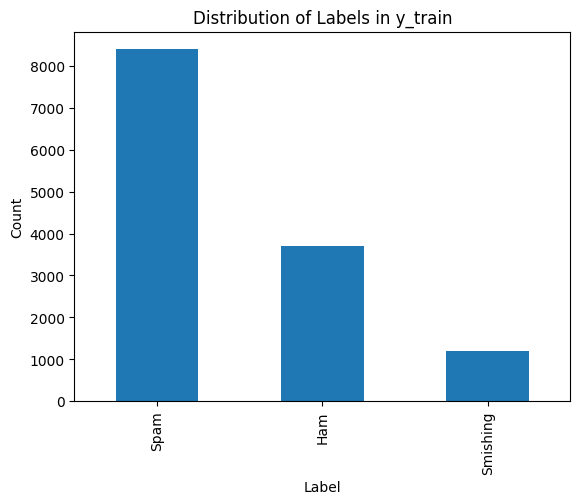

In [48]:
label_counts = y_train.value_counts()
label_counts.plot(kind='bar')
plt.title('Distribution of Labels in y_train')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [49]:
y_test.value_counts()

Spam        3599
Ham         1592
Smishing     515
Name: Label, dtype: int64

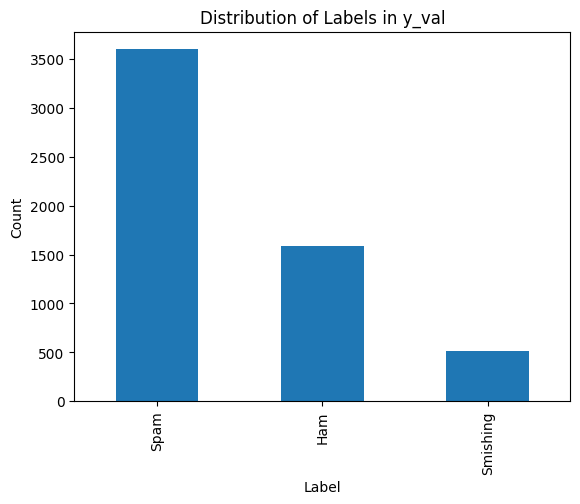

In [50]:
label_counts = y_test.value_counts()
label_counts.plot(kind='bar')
plt.title('Distribution of Labels in y_val')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

## Hyper Parameters setting


In [51]:
# 4
#    Set your hyperparameters:

#    epochs,
#    batch size,
#    dimension,
#    unique words,
#    stop words,
#    maximum message length,
#    padding type,
#    truncation type,
#    #dense layer,
#    dropout,
#    n_filters,
#    optimizers,
#    or anything else needed.

num_classes= 3

output_dir = 'model_output/dense'
epochs = 7
batch_size = 128

n_dim = 100
n_unique_words = 5000
total_elements = 5405
n_words_to_skip = 50
pad_type = trunc_type = 'pre'
n_dense = 100
dropout = 0.5

#CNN
cnn_max_review =100
cnn_dense = 256
cnn_dropout = 0.2
n_conv = 256
k_conv = 3

#RNN
n_rnn = 256
drop_rnn = 0.2
drop_embed = 0.2

#LSTM
out_put_ = 'model_output/conv'
lstm_max_review = 100
lstm_drop_embed = 0.2
lstm_n_conv = 256
lstm_k_conv = 0.2
lstm_dropout = 0.2

In [52]:
# LSTM layer architecture:
n_lstm = 256
drop_lstm = 0.2

# CNN architecture
n_conv = 64
k_conv = 3
mp_size=4

# GRU architecture
n_gru = 256
drop_gru = 0.2

# LSTM stack layer architecture
n_lstm_1 = 64
n_lstm_2 = 64
drop_lstm = 0.2

# Multi conv (Non-sequential)
n_conv_1 = n_conv_2 = n_conv_3 = 256
k_conv_1 = 3
k_conv_2 = 2
k_conv_3 = 4

## Preprocessing


In [53]:
# 3
# Apply all ( or subset of) the preprocessing steps that we learned in the class:
# Tokenization
# Convertion to lowercase
# Removing stop words
# Removing puntuation
# Stemming
# n-grams

max_message_length = 100

from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer()
vect.fit(x_train)

# Tokenizing
token = Tokenizer(num_words=n_unique_words)
token.fit_on_texts(x_train)

x_train_emb = token.texts_to_sequences(x_train)
x_test_emb = token.texts_to_sequences(x_test)

print(x_train[0])
print(x_train_emb[0])

x_train = pad_sequences(x_train_emb, padding='pre', maxlen=max_message_length)
x_test = pad_sequences(x_test_emb, padding='pre', maxlen=max_message_length)

print(x_train[1])

CASH BUY AND HOLD XXXXX SHARES OF ALPSMOTOR XXXXXX ABOVE Rs 28.50 THIS WEEK TARGET Rs 35,40,45 STOP LOSS Rs XX DONT MISS IT
[191, 1143, 1118, 717]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0  842    1  222    4 1144
  376   30]


In [54]:
y_train_original = y_train
y_test_original = y_test

In [55]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

## Model 1 Dense

In [56]:
from keras.callbacks import ModelCheckpoint

# Output Directory name:
output_dir = 'model_output/dense' # Store model's parameter after each epoch, useful at a later time

# If the output_dir directory doesn't exist, we use the mkdirs() method to make it
if not os.path.exists(output_dir):
  os.makedirs(output_dir)

# Allow to save our model parameters after each epoch during training
modelcheckpoint = ModelCheckpoint(filepath = output_dir + '/weights.{epoch:02d}.hdf5')

In [57]:
from tensorflow.keras.layers import Embedding, SpatialDropout1D, Conv1D, GlobalMaxPool1D, SimpleRNN, LSTM, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Dense
model1 = Sequential()
model1.add(Embedding(n_unique_words, n_dim, input_length=max_message_length))
model1.add(Flatten())
model1.add(Dense(n_dense, activation='relu'))
model1.add(Dropout(dropout))
model1.add(Dense(n_dense, activation='relu'))
model1.add(Dropout(dropout))
model1.add(Dense(num_classes, activation='softmax'))  # Change to num_classes

# Compile
model1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model1.summary()

start_time = time.time()
history1 = model1.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, y_test), callbacks=[modelcheckpoint])
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          500000    
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 100)               1000100   
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 3)                 3

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


104/104 [==============================] - 10s 97ms/step - loss: 0.2171 - accuracy: 0.9180 - val_loss: 0.1825 - val_accuracy: 0.9317
Epoch 3/7
104/104 [==============================] - 7s 66ms/step - loss: 0.1149 - accuracy: 0.9627 - val_loss: 0.1722 - val_accuracy: 0.9404
Epoch 4/7
104/104 [==============================] - 3s 31ms/step - loss: 0.0675 - accuracy: 0.9764 - val_loss: 0.1933 - val_accuracy: 0.9409
Epoch 5/7
104/104 [==============================] - 3s 29ms/step - loss: 0.0452 - accuracy: 0.9846 - val_loss: 0.1989 - val_accuracy: 0.9448
Epoch 6/7
104/104 [==============================] - 3s 27ms/step - loss: 0.0379 - accuracy: 0.9863 - val_loss: 0.2118 - val_accuracy: 0.9439
Epoch 7/7
104/104 [==============================] - 3s 28ms/step - loss: 0.0303 - accuracy: 0.9890 - val_loss: 0.2266 - val_accuracy: 0.9437

Duration: 67 seconds


### Evaluate

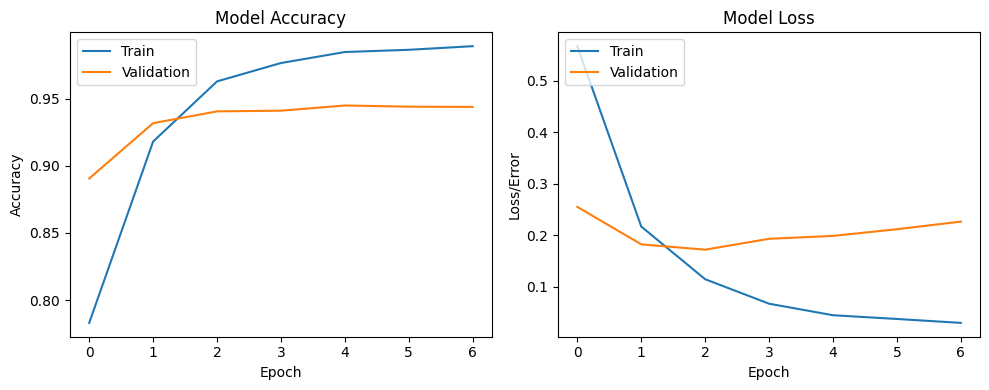

In [58]:
plt.figure(figsize=(10, 4))

# Visualizing training and validation accuracy for this Model
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Visualizing training and validation loss for this Model
plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss/Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [59]:
from sklearn.metrics import accuracy_score
import numpy as np

# Evaluating the model
y_pred_prob = model1.predict(x_test)
y_pred = y_pred_prob.argmax(axis=-1)

# Calculating accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {100*accuracy:.2f}")

179/179 [==============================] - 1s 3ms/step
Model Accuracy: 94.37


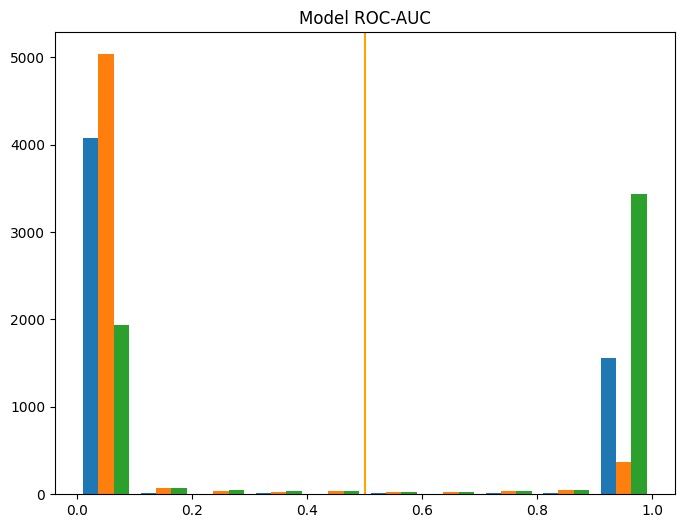

In [60]:
# Plot ROC curve for model
plt.figure(figsize=(8, 6))
plt.hist(y_pred_prob)
_ = plt.axvline(x=0.5, color='orange')
plt.title("Model ROC-AUC")
plt.show()

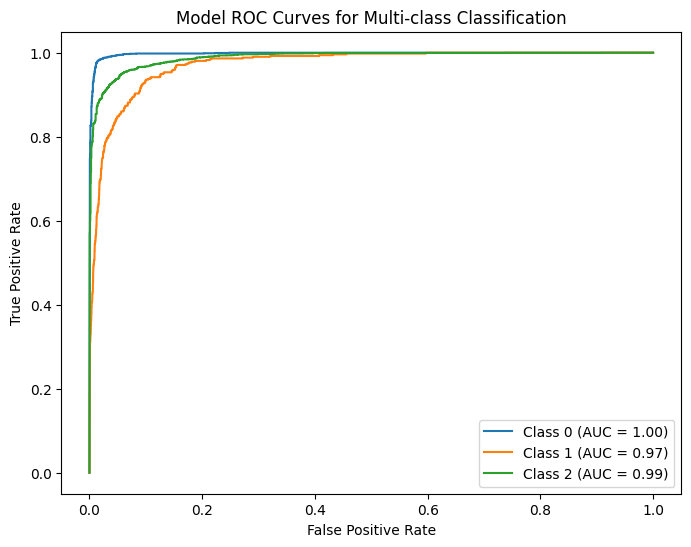

In [61]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_test_encoded and y_pred_prob are defined
# y_test_encoded: True labels (encoded, not one-hot encoded)
# y_pred_prob: Predicted probabilities for each class

# Calculate ROC-AUC score for model (one-vs-all approach for multi-class)
roc_auc = []

# Create a figure and axis
plt.figure(figsize=(8, 6))

# Plot ROC curve for each class
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test== i, y_pred_prob[:, i])
    roc_auc_class = auc(fpr, tpr)
    roc_auc.append(roc_auc_class * 100.0)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc_class:.2f})')

# Set plot title and labels
plt.title("Model ROC Curves for Multi-class Classification")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

## Model 2 CNN

In [62]:
# Output Directory name:
output_dir = 'model_output/CNN' # Store model's parameter after each epoch, useful at a later time

# Allow to save our model parameters after each epoch during training
modelcheckpoint = ModelCheckpoint(filepath = output_dir + '/weights.{epoch:02d}.hdf5')

# If the output_dir directory doesn't exist, we use the mkdirs() method to make it
if not os.path.exists(output_dir):
  os.makedirs(output_dir)

In [63]:
# CNN
model2 = Sequential()
model2.add(Embedding(n_unique_words, n_dim, input_length=cnn_max_review))
model2.add(SpatialDropout1D(drop_embed))
model2.add(Conv1D(n_conv, k_conv, activation='relu'))
model2.add(GlobalMaxPool1D())
model2.add(Dense(cnn_dense, activation='relu'))
model2.add(Dropout(cnn_dropout))
model2.add(Dense(num_classes, activation='softmax'))  # Change to num_classes
model2.summary()

model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

start_time = time.time()
history2 = model2.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, y_test), callbacks=[modelcheckpoint])
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          500000    
                                                                 
 spatial_dropout1d (Spatial  (None, 100, 100)          0         
 Dropout1D)                                                      
                                                                 
 conv1d (Conv1D)             (None, 98, 64)            19264     
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_3 (Dense)             (None, 256)               16640     
                                                                 
 dropout_2 (Dropout)         (None, 256)              

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


104/104 [==============================] - 9s 84ms/step - loss: 0.1763 - accuracy: 0.9310 - val_loss: 0.1621 - val_accuracy: 0.9362
Epoch 3/7
104/104 [==============================] - 5s 46ms/step - loss: 0.1020 - accuracy: 0.9613 - val_loss: 0.1472 - val_accuracy: 0.9429
Epoch 4/7
104/104 [==============================] - 6s 57ms/step - loss: 0.0625 - accuracy: 0.9760 - val_loss: 0.1494 - val_accuracy: 0.9457
Epoch 5/7
104/104 [==============================] - 4s 35ms/step - loss: 0.0457 - accuracy: 0.9826 - val_loss: 0.1575 - val_accuracy: 0.9469
Epoch 6/7
104/104 [==============================] - 2s 22ms/step - loss: 0.0375 - accuracy: 0.9863 - val_loss: 0.1723 - val_accuracy: 0.9437
Epoch 7/7
104/104 [==============================] - 2s 21ms/step - loss: 0.0331 - accuracy: 0.9870 - val_loss: 0.1726 - val_accuracy: 0.9451

Duration: 47 seconds


### Evaluate

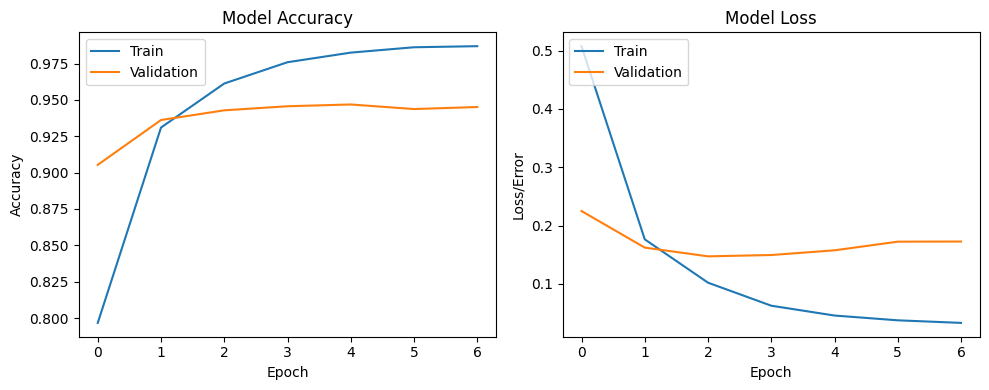

In [64]:
plt.figure(figsize=(10, 4))

# Visualizing training and validation accuracy for this Model
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Visualizing training and validation loss for this Model
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss/Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [65]:
from sklearn.metrics import accuracy_score
import numpy as np

# Evaluating the model
y_pred_prob = model2.predict(x_test)
y_pred = y_pred_prob.argmax(axis=-1)

# Calculating accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {100*accuracy:.2f}")

179/179 [==============================] - 1s 4ms/step
Model Accuracy: 94.51


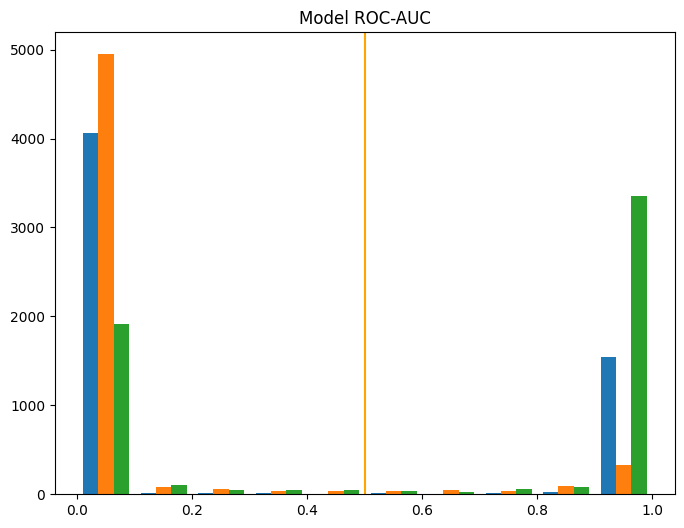

In [66]:
# Plot ROC curve for model
plt.figure(figsize=(8, 6))
plt.hist(y_pred_prob)
_ = plt.axvline(x=0.5, color='orange')
plt.title("Model ROC-AUC")
plt.show()

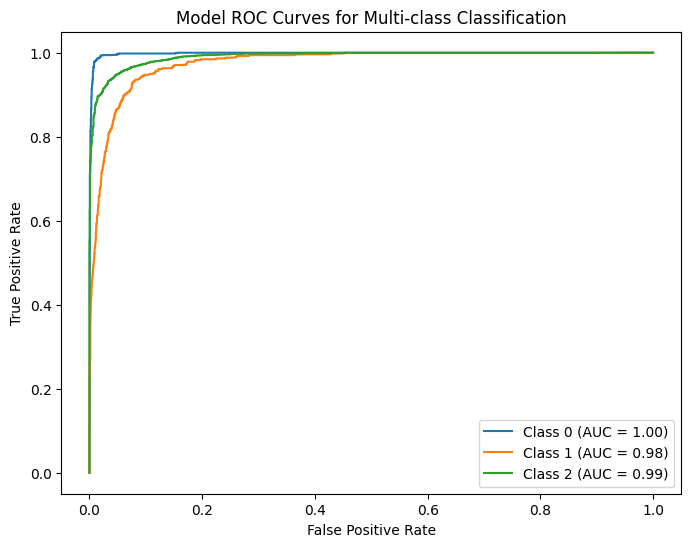

In [67]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_test_encoded and y_pred_prob are defined
# y_test_encoded: True labels (encoded, not one-hot encoded)
# y_pred_prob: Predicted probabilities for each class

# Calculate ROC-AUC score for model (one-vs-all approach for multi-class)
roc_auc = []

# Create a figure and axis
plt.figure(figsize=(8, 6))

# Plot ROC curve for each class
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test== i, y_pred_prob[:, i])
    roc_auc_class = auc(fpr, tpr)
    roc_auc.append(roc_auc_class * 100.0)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc_class:.2f})')

# Set plot title and labels
plt.title("Model ROC Curves for Multi-class Classification")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

## Model 3 RNN

In [68]:
# Output Directory name:
output_dir = 'model_output/Simple RNN' # Store model's parameter after each epoch, useful at a later time

# If the output_dir directory doesn't exist, we use the mkdirs() method to make it
if not os.path.exists(output_dir):
  os.makedirs(output_dir)

# Allow to save our model parameters after each epoch during training
modelcheckpoint = ModelCheckpoint(filepath = output_dir + '/weights.{epoch:02d}.hdf5')

drop_embed = 0.2
n_rnn = 256
drop_rnn = 0.2
#n_dense = 256
#dropout = 0.2

In [69]:
# RNN
model3 = Sequential()
model3.add(Embedding(n_unique_words, n_dim, input_length=max_message_length))
model3.add(SpatialDropout1D(drop_embed))
model3.add(SimpleRNN(n_rnn, dropout=drop_rnn))
model3.add(Dense(num_classes, activation='softmax'))  # Change to num_classes

model3.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model3.summary()

start_time = time.time()
history3 = model3.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, y_test), callbacks=[modelcheckpoint])
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          500000    
                                                                 
 spatial_dropout1d_1 (Spati  (None, 100, 100)          0         
 alDropout1D)                                                    
                                                                 
 simple_rnn (SimpleRNN)      (None, 256)               91392     
                                                                 
 dense_5 (Dense)             (None, 3)                 771       
                                                                 
Total params: 592163 (2.26 MB)
Trainable params: 592163 (2.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/7
104/104 [==============================] - 29s 261ms/step - loss: 0.9382 -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


104/104 [==============================] - 13s 127ms/step - loss: 0.7852 - accuracy: 0.6664 - val_loss: 0.6570 - val_accuracy: 0.7441
Epoch 3/7
104/104 [==============================] - 14s 131ms/step - loss: 0.4808 - accuracy: 0.8445 - val_loss: 0.3646 - val_accuracy: 0.8680
Epoch 4/7
104/104 [==============================] - 11s 104ms/step - loss: 0.3166 - accuracy: 0.8859 - val_loss: 0.3194 - val_accuracy: 0.8852
Epoch 5/7
104/104 [==============================] - 15s 147ms/step - loss: 0.2493 - accuracy: 0.9043 - val_loss: 0.2458 - val_accuracy: 0.9041
Epoch 6/7
104/104 [==============================] - 14s 137ms/step - loss: 0.2127 - accuracy: 0.9195 - val_loss: 0.2994 - val_accuracy: 0.8929
Epoch 7/7
104/104 [==============================] - 11s 104ms/step - loss: 0.1709 - accuracy: 0.9352 - val_loss: 0.2385 - val_accuracy: 0.9108

Duration: 143 seconds


### Evaluate

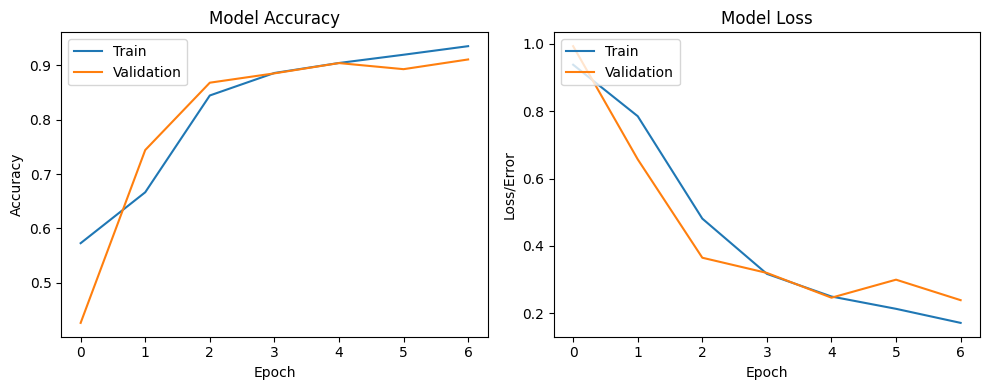

In [70]:
plt.figure(figsize=(10, 4))

# Visualizing training and validation accuracy for this Model
plt.subplot(1, 2, 1)
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Visualizing training and validation loss for this Model
plt.subplot(1, 2, 2)
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss/Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [71]:
from sklearn.metrics import accuracy_score
import numpy as np

# Evaluating the model
y_pred_prob = model3.predict(x_test)
y_pred = y_pred_prob.argmax(axis=-1)

# Calculating accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {100*accuracy:.2f}")

179/179 [==============================] - 2s 9ms/step
Model Accuracy: 91.08


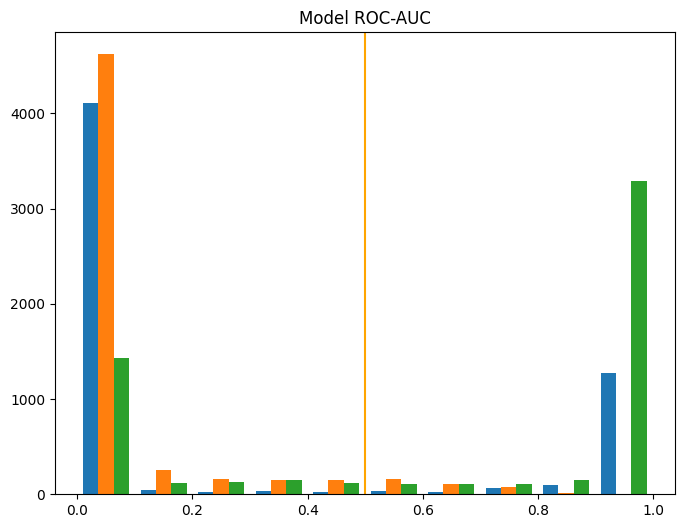

In [72]:
# Plot ROC curve for model
plt.figure(figsize=(8, 6))
plt.hist(y_pred_prob)
_ = plt.axvline(x=0.5, color='orange')
plt.title("Model ROC-AUC")
plt.show()

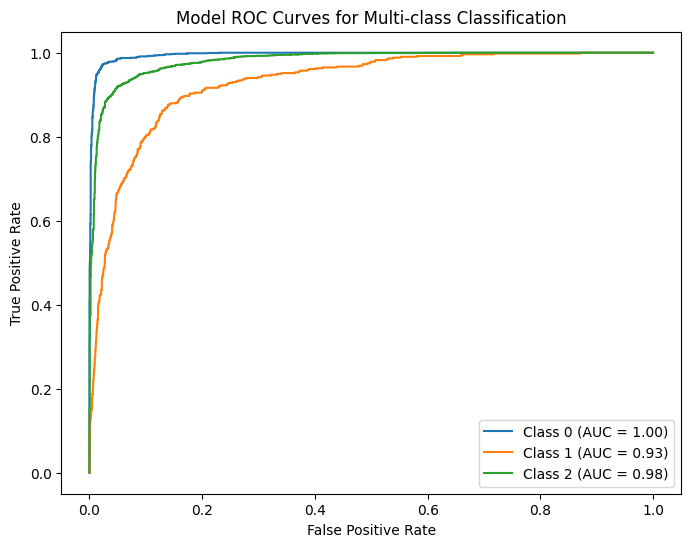

In [73]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_test_encoded and y_pred_prob are defined
# y_test_encoded: True labels (encoded, not one-hot encoded)
# y_pred_prob: Predicted probabilities for each class

# Calculate ROC-AUC score for model (one-vs-all approach for multi-class)
roc_auc = []

# Create a figure and axis
plt.figure(figsize=(8, 6))

# Plot ROC curve for each class
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test== i, y_pred_prob[:, i])
    roc_auc_class = auc(fpr, tpr)
    roc_auc.append(roc_auc_class * 100.0)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc_class:.2f})')

# Set plot title and labels
plt.title("Model ROC Curves for Multi-class Classification")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

## Model 4 LSTM

In [74]:
# Output Directory name:
output_dir = 'model_output/LSTM' # Store model's parameter after each epoch, useful at a later time

# If the output_dir directory doesn't exist, we use the mkdirs() method to make it
if not os.path.exists(output_dir):
  os.makedirs(output_dir)

# Allow to save our model parameters after each epoch during training
modelcheckpoint = ModelCheckpoint(filepath = output_dir + '/weights.{epoch:02d}.hdf5')


In [75]:
# LSTM
model4 = Sequential()
model4.add(Embedding(n_unique_words, n_dim, input_length=lstm_max_review))
model4.add(SpatialDropout1D(lstm_drop_embed))
model4.add(LSTM(n_lstm, dropout=lstm_dropout))
model4.add(Dense(num_classes, activation='softmax'))  # Change to num_classes

model4.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model4.summary()

start_time = time.time()
history4 = model4.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, y_test), callbacks=[modelcheckpoint])
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 100)          500000    
                                                                 
 spatial_dropout1d_2 (Spati  (None, 100, 100)          0         
 alDropout1D)                                                    
                                                                 
 lstm (LSTM)                 (None, 256)               365568    
                                                                 
 dense_6 (Dense)             (None, 3)                 771       
                                                                 
Total params: 866339 (3.30 MB)
Trainable params: 866339 (3.30 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/7
104/104 [==============================] - 13s 104ms/step - loss: 0.4449 -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


104/104 [==============================] - 6s 55ms/step - loss: 0.1631 - accuracy: 0.9409 - val_loss: 0.1497 - val_accuracy: 0.9427
Epoch 3/7
104/104 [==============================] - 4s 40ms/step - loss: 0.1155 - accuracy: 0.9556 - val_loss: 0.1589 - val_accuracy: 0.9434
Epoch 4/7
104/104 [==============================] - 3s 29ms/step - loss: 0.0826 - accuracy: 0.9692 - val_loss: 0.1453 - val_accuracy: 0.9450
Epoch 5/7
104/104 [==============================] - 3s 26ms/step - loss: 0.0634 - accuracy: 0.9750 - val_loss: 0.1476 - val_accuracy: 0.9469
Epoch 6/7
104/104 [==============================] - 3s 24ms/step - loss: 0.0528 - accuracy: 0.9795 - val_loss: 0.1546 - val_accuracy: 0.9455
Epoch 7/7
104/104 [==============================] - 3s 26ms/step - loss: 0.0513 - accuracy: 0.9802 - val_loss: 0.1789 - val_accuracy: 0.9416

Duration: 43 seconds


### Evaluate

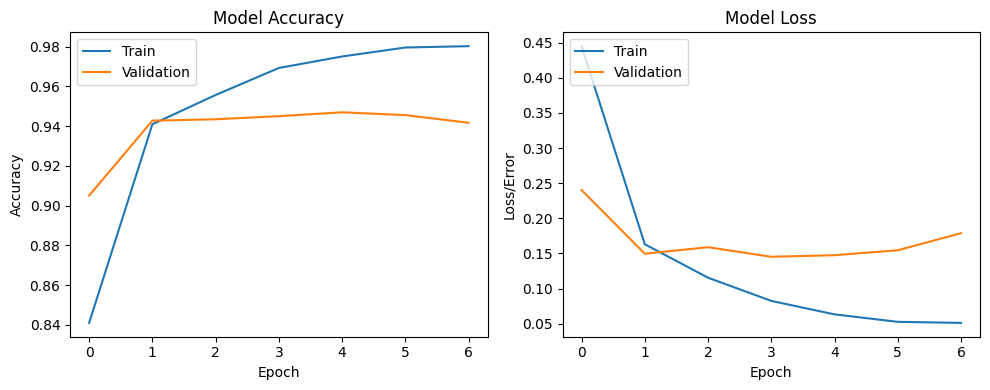

In [76]:
plt.figure(figsize=(10, 4))

# Visualizing training and validation accuracy for this Model
plt.subplot(1, 2, 1)
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Visualizing training and validation loss for this Model
plt.subplot(1, 2, 2)
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss/Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [77]:
from sklearn.metrics import accuracy_score
import numpy as np
# Output Directory name:
output_dir = 'model_output/LSTM'
# Evaluating the model
model4.load_weights(output_dir + "/weights.04.hdf5")
y_pred_prob = model4.predict(x_test)
y_pred = y_pred_prob.argmax(axis=-1)

# Calculating accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {100*accuracy:.2f}")

179/179 [==============================] - 1s 4ms/step
Model Accuracy: 94.50


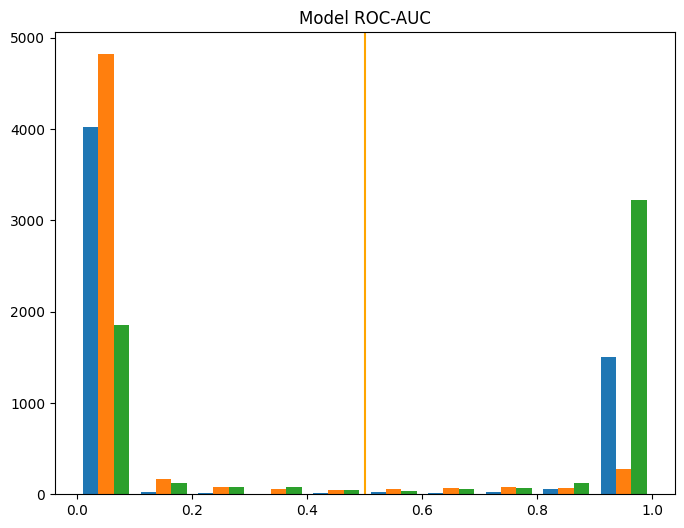

In [78]:
# Plot ROC curve for model
plt.figure(figsize=(8, 6))
plt.hist(y_pred_prob)
_ = plt.axvline(x=0.5, color='orange')
plt.title("Model ROC-AUC")
plt.show()

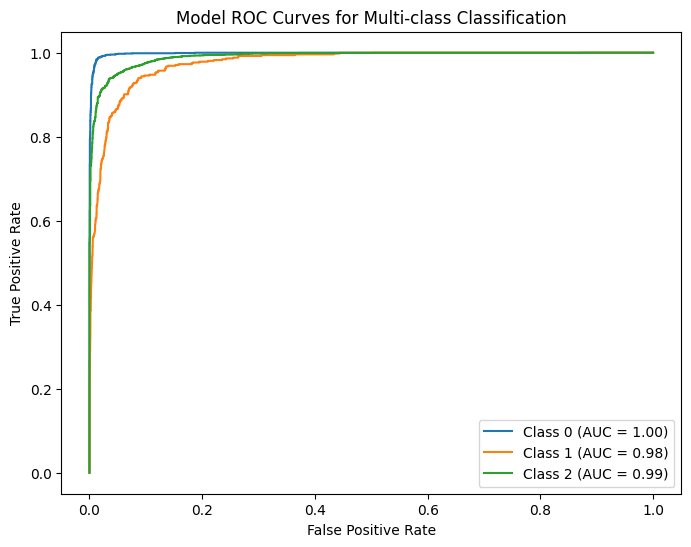

In [79]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_test_encoded and y_pred_prob are defined
# y_test_encoded: True labels (encoded, not one-hot encoded)
# y_pred_prob: Predicted probabilities for each class

# Calculate ROC-AUC score for model (one-vs-all approach for multi-class)
roc_auc = []

# Create a figure and axis
plt.figure(figsize=(8, 6))

# Plot ROC curve for each class
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test== i, y_pred_prob[:, i])
    roc_auc_class = auc(fpr, tpr)
    roc_auc.append(roc_auc_class * 100.0)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc_class:.2f})')

# Set plot title and labels
plt.title("Model ROC Curves for Multi-class Classification")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

## Model 5 Improved CNN

In [80]:
# Output Directory name:
output_dir = 'model_output/Improved-CNN' # Store model's parameter after each epoch, useful at a later time

# If the output_dir directory doesn't exist, we use the mkdirs() method to make it
if not os.path.exists(output_dir):
  os.makedirs(output_dir)

# Allow to save our model parameters after each epoch during training
modelcheckpoint = ModelCheckpoint(filepath = output_dir + '/weights.{epoch:02d}.hdf5')

In [81]:
#    Tune your model
# Select the model which performed the best in the previous step and then tune the hyperparameters
# Improved CNN
model5 = Sequential()

model5.add(Embedding(n_unique_words, n_dim, input_length=cnn_max_review))
model5.add(SpatialDropout1D(drop_embed))

model5.add(Conv1D(n_conv,k_conv,activation = 'relu'))
model5.add(GlobalMaxPool1D())

model5.add(Dense(64, activation='relu'))
model5.add(Dense(128,activation='relu'))
model5.add(Dropout(0.4))
model5.add(Dense(num_classes, activation='softmax'))

model5.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model5.summary()

start_time = time.time()
history5 =  model5.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, y_test), callbacks=[modelcheckpoint])
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 100)          500000    
                                                                 
 spatial_dropout1d_3 (Spati  (None, 100, 100)          0         
 alDropout1D)                                                    
                                                                 
 conv1d_1 (Conv1D)           (None, 98, 64)            19264     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 128)              

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


104/104 [==============================] - 10s 90ms/step - loss: 0.1689 - accuracy: 0.9347 - val_loss: 0.1499 - val_accuracy: 0.9439
Epoch 3/7
104/104 [==============================] - 4s 42ms/step - loss: 0.0901 - accuracy: 0.9676 - val_loss: 0.1500 - val_accuracy: 0.9423
Epoch 4/7
104/104 [==============================] - 3s 34ms/step - loss: 0.0582 - accuracy: 0.9801 - val_loss: 0.1587 - val_accuracy: 0.9420
Epoch 5/7
104/104 [==============================] - 2s 23ms/step - loss: 0.0431 - accuracy: 0.9849 - val_loss: 0.1655 - val_accuracy: 0.9420
Epoch 6/7
104/104 [==============================] - 3s 25ms/step - loss: 0.0386 - accuracy: 0.9862 - val_loss: 0.1682 - val_accuracy: 0.9444
Epoch 7/7
104/104 [==============================] - 1s 13ms/step - loss: 0.0328 - accuracy: 0.9872 - val_loss: 0.1713 - val_accuracy: 0.9457

Duration: 42 seconds


### Evaluate

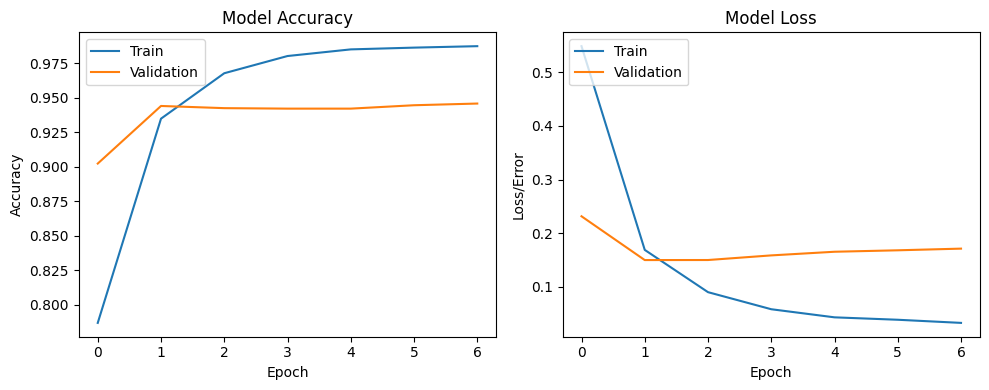

In [82]:
plt.figure(figsize=(10, 4))

# Visualizing training and validation accuracy for this Model
plt.subplot(1, 2, 1)
plt.plot(history5.history['accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Visualizing training and validation loss for this Model
plt.subplot(1, 2, 2)
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss/Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [83]:
from sklearn.metrics import accuracy_score
import numpy as np

# Evaluating the model
y_pred_prob = model5.predict(x_test)
y_pred = y_pred_prob.argmax(axis=-1)

# Calculating accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {100*accuracy:.2f}")

179/179 [==============================] - 0s 2ms/step
Model Accuracy: 94.57


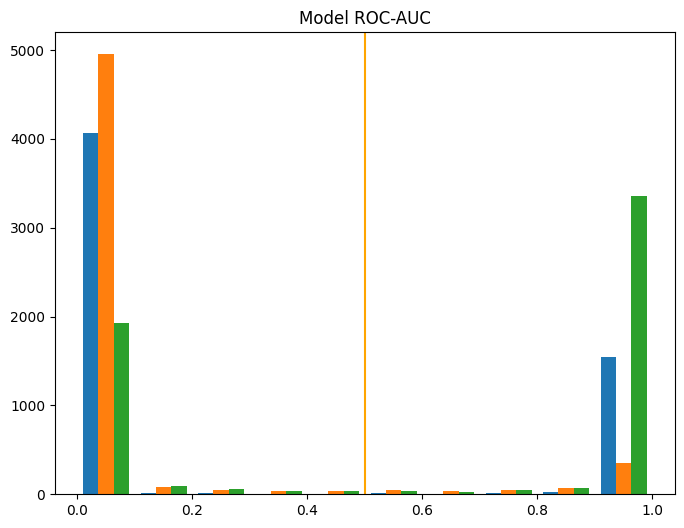

In [84]:
# Plot ROC curve for model
plt.figure(figsize=(8, 6))
plt.hist(y_pred_prob)
_ = plt.axvline(x=0.5, color='orange')
plt.title("Model ROC-AUC")
plt.show()

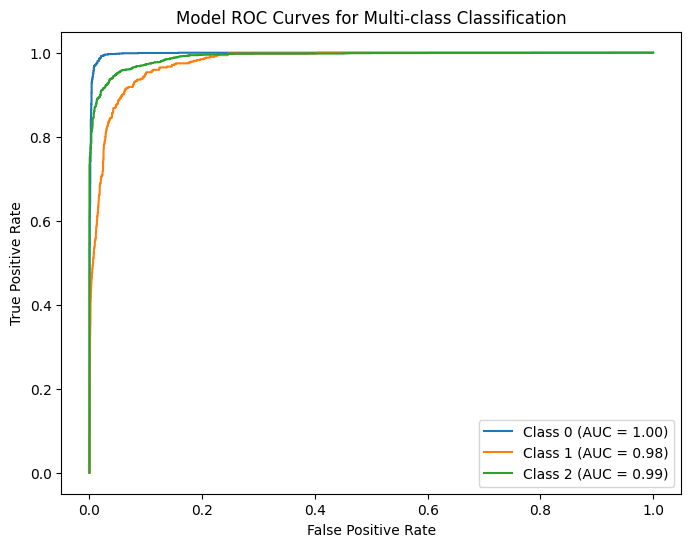

In [85]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_test_encoded and y_pred_prob are defined
# y_test_encoded: True labels (encoded, not one-hot encoded)
# y_pred_prob: Predicted probabilities for each class

# Calculate ROC-AUC score for model (one-vs-all approach for multi-class)
roc_auc = []

# Create a figure and axis
plt.figure(figsize=(8, 6))

# Plot ROC curve for each class
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test== i, y_pred_prob[:, i])
    roc_auc_class = auc(fpr, tpr)
    roc_auc.append(roc_auc_class * 100.0)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc_class:.2f})')

# Set plot title and labels
plt.title("Model ROC Curves for Multi-class Classification")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

## Model 6 GRU

In [86]:
# Output Directory name:
output_dir = 'model_output/GRU' # Store model's parameter after each epoch, useful at a later time

# If the output_dir directory doesn't exist, we use the mkdirs() method to make it
if not os.path.exists(output_dir):
  os.makedirs(output_dir)

# Allow to save our model parameters after each epoch during training
modelcheckpoint = ModelCheckpoint(filepath = output_dir + '/weights.{epoch:02d}.hdf5')

In [87]:
# GRU
model6 = Sequential()
model6.add(Embedding(n_unique_words, n_dim, input_length=max_message_length))
model6.add(SpatialDropout1D(drop_embed))
model6.add(GRU(n_gru, dropout=drop_gru))
model6.add(Dense(num_classes, activation='softmax'))

model6.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model6.summary()

start_time = time.time()
historyGRU =  model6.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, y_test), callbacks=[modelcheckpoint])
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 100)          500000    
                                                                 
 spatial_dropout1d_4 (Spati  (None, 100, 100)          0         
 alDropout1D)                                                    
                                                                 
 gru (GRU)                   (None, 256)               274944    
                                                                 
 dense_10 (Dense)            (None, 3)                 771       
                                                                 
Total params: 775715 (2.96 MB)
Trainable params: 775715 (2.96 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/7
104/104 [==============================] - 12s 99ms/step - loss: 0.4223 - 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


104/104 [==============================] - 5s 47ms/step - loss: 0.1828 - accuracy: 0.9289 - val_loss: 0.1761 - val_accuracy: 0.9359
Epoch 3/7
104/104 [==============================] - 4s 40ms/step - loss: 0.1143 - accuracy: 0.9587 - val_loss: 0.1532 - val_accuracy: 0.9418
Epoch 4/7
104/104 [==============================] - 4s 35ms/step - loss: 0.0778 - accuracy: 0.9703 - val_loss: 0.1535 - val_accuracy: 0.9430
Epoch 5/7
104/104 [==============================] - 3s 26ms/step - loss: 0.0608 - accuracy: 0.9775 - val_loss: 0.2062 - val_accuracy: 0.9339
Epoch 6/7
104/104 [==============================] - 2s 22ms/step - loss: 0.0541 - accuracy: 0.9793 - val_loss: 0.1749 - val_accuracy: 0.9387
Epoch 7/7
104/104 [==============================] - 2s 20ms/step - loss: 0.0438 - accuracy: 0.9836 - val_loss: 0.1884 - val_accuracy: 0.9411

Duration: 32 seconds


### Evaluate

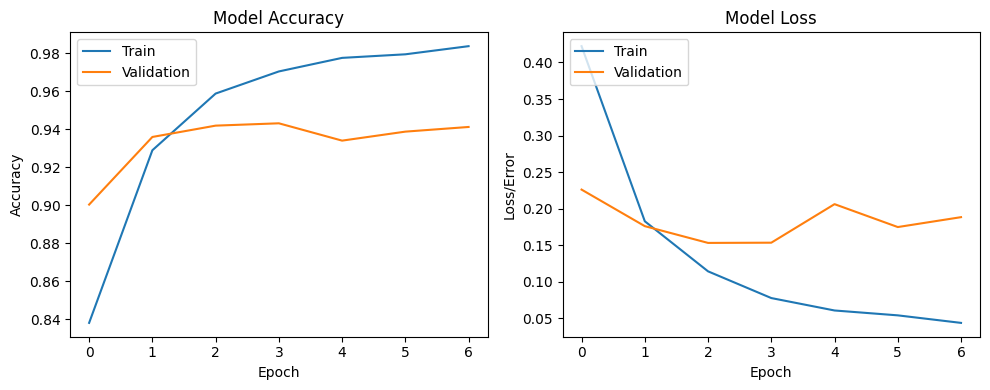

In [88]:
plt.figure(figsize=(10, 4))

# Visualizing training and validation accuracy for this Model
plt.subplot(1, 2, 1)
plt.plot(historyGRU.history['accuracy'])
plt.plot(historyGRU.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Visualizing training and validation loss for this Model
plt.subplot(1, 2, 2)
plt.plot(historyGRU.history['loss'])
plt.plot(historyGRU.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss/Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [89]:
from sklearn.metrics import accuracy_score
import numpy as np

# Evaluating the model
y_pred_prob = model6.predict(x_test)
y_pred = y_pred_prob.argmax(axis=-1)

# Calculating accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {100*accuracy:.2f}")

179/179 [==============================] - 1s 4ms/step
Model Accuracy: 94.11


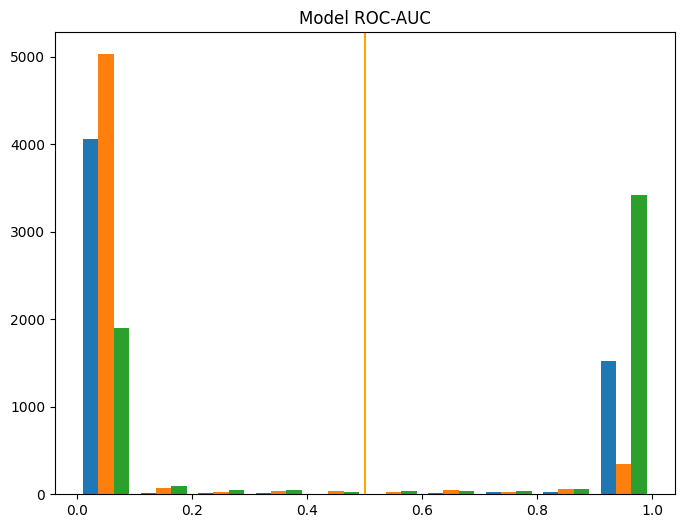

In [90]:
# Plot ROC curve for model
plt.figure(figsize=(8, 6))
plt.hist(y_pred_prob)
_ = plt.axvline(x=0.5, color='orange')
plt.title("Model ROC-AUC")
plt.show()

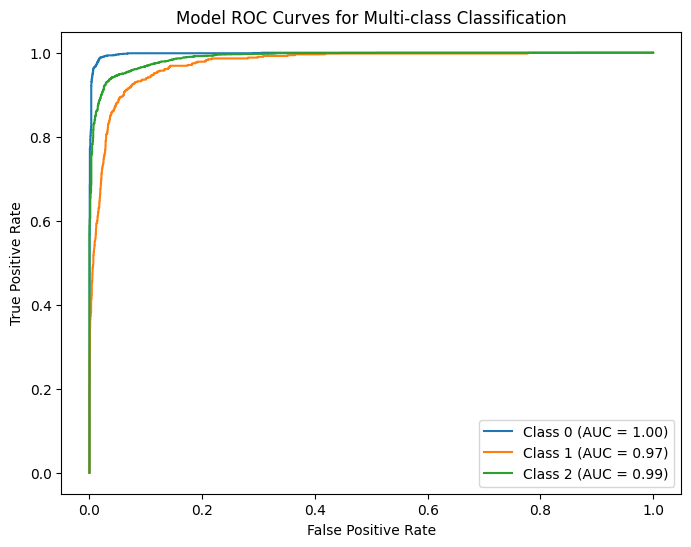

In [91]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_test_encoded and y_pred_prob are defined
# y_test_encoded: True labels (encoded, not one-hot encoded)
# y_pred_prob: Predicted probabilities for each class

# Calculate ROC-AUC score for model (one-vs-all approach for multi-class)
roc_auc = []

# Create a figure and axis
plt.figure(figsize=(8, 6))

# Plot ROC curve for each class
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test== i, y_pred_prob[:, i])
    roc_auc_class = auc(fpr, tpr)
    roc_auc.append(roc_auc_class * 100.0)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc_class:.2f})')

# Set plot title and labels
plt.title("Model ROC Curves for Multi-class Classification")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

## Model 7 Bi-LSTM

In [92]:
# Output Directory name:
output_dir = 'model_output/Bi-LSTM' # Store model's parameter after each epoch, useful at a later time

# If the output_dir directory doesn't exist, we use the mkdirs() method to make it
if not os.path.exists(output_dir):
  os.makedirs(output_dir)

# Allow to save our model parameters after each epoch during training
modelcheckpoint = ModelCheckpoint(filepath = output_dir + '/weights.{epoch:02d}.hdf5')

In [93]:
# 7
model7 = Sequential()
model7.add(Embedding(n_unique_words, n_dim, input_length=max_message_length))
model7.add(SpatialDropout1D(drop_embed))
model7.add(Bidirectional(LSTM(n_lstm_1, dropout=0.4, return_sequences=True)))
model7.add(Bidirectional(LSTM(n_lstm_2, dropout=0.4)))
model7.add(Dense(num_classes, activation='softmax'))

model7.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model7.summary()

start_time = time.time()
history7 =  model7.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, y_test), callbacks=[modelcheckpoint])
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 100)          500000    
                                                                 
 spatial_dropout1d_5 (Spati  (None, 100, 100)          0         
 alDropout1D)                                                    
                                                                 
 bidirectional (Bidirection  (None, 100, 128)          84480     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                                 
 dense_11 (Dense)            (None, 3)                 387       
                                                      

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


104/104 [==============================] - 7s 66ms/step - loss: 0.1606 - accuracy: 0.9417 - val_loss: 0.1554 - val_accuracy: 0.9399
Epoch 3/7
104/104 [==============================] - 4s 36ms/step - loss: 0.1084 - accuracy: 0.9612 - val_loss: 0.1437 - val_accuracy: 0.9409
Epoch 4/7
104/104 [==============================] - 5s 46ms/step - loss: 0.0813 - accuracy: 0.9714 - val_loss: 0.1581 - val_accuracy: 0.9443
Epoch 5/7
104/104 [==============================] - 6s 54ms/step - loss: 0.0690 - accuracy: 0.9752 - val_loss: 0.1546 - val_accuracy: 0.9460
Epoch 6/7
104/104 [==============================] - 3s 30ms/step - loss: 0.0571 - accuracy: 0.9792 - val_loss: 0.1621 - val_accuracy: 0.9439
Epoch 7/7
104/104 [==============================] - 3s 31ms/step - loss: 0.0471 - accuracy: 0.9822 - val_loss: 0.1722 - val_accuracy: 0.9455

Duration: 46 seconds


### Evaluate

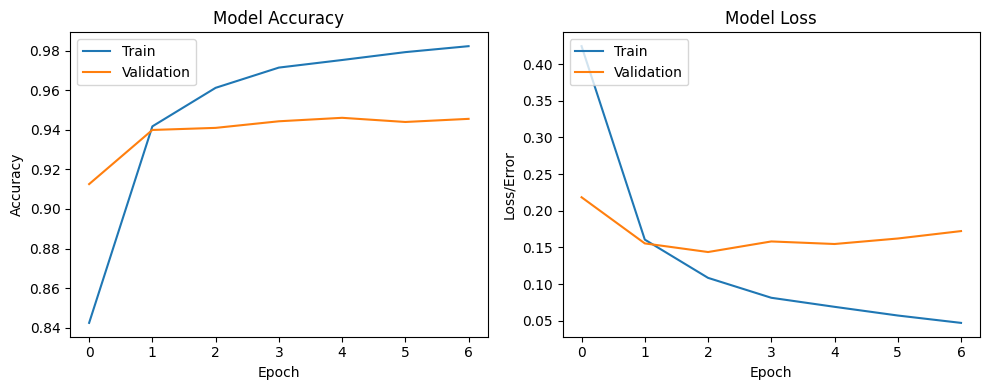

In [94]:
plt.figure(figsize=(10, 4))

# Visualizing training and validation accuracy for this Model
plt.subplot(1, 2, 1)
plt.plot(history7.history['accuracy'])
plt.plot(history7.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Visualizing training and validation loss for this Model
plt.subplot(1, 2, 2)
plt.plot(history7.history['loss'])
plt.plot(history7.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss/Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [95]:
from sklearn.metrics import accuracy_score
import numpy as np

# Evaluating the model
y_pred_prob = model7.predict(x_test)
y_pred = y_pred_prob.argmax(axis=-1)

# Calculating accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {100*accuracy:.2f}")

179/179 [==============================] - 3s 10ms/step
Model Accuracy: 94.55


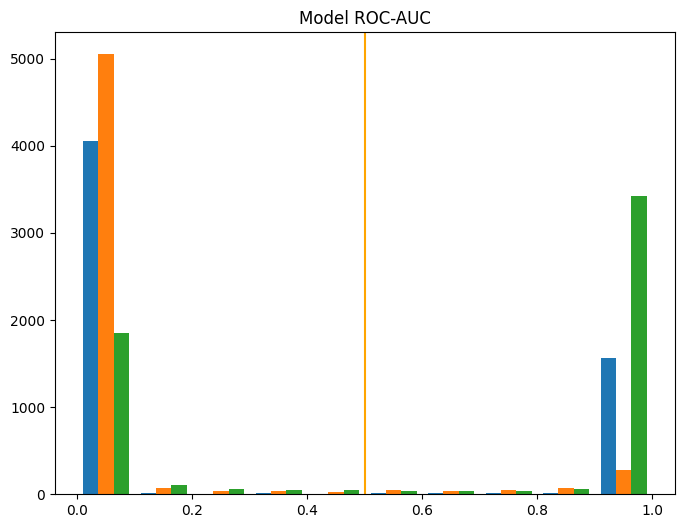

In [96]:
# Plot ROC curve for model
plt.figure(figsize=(8, 6))
plt.hist(y_pred_prob)
_ = plt.axvline(x=0.5, color='orange')
plt.title("Model ROC-AUC")
plt.show()

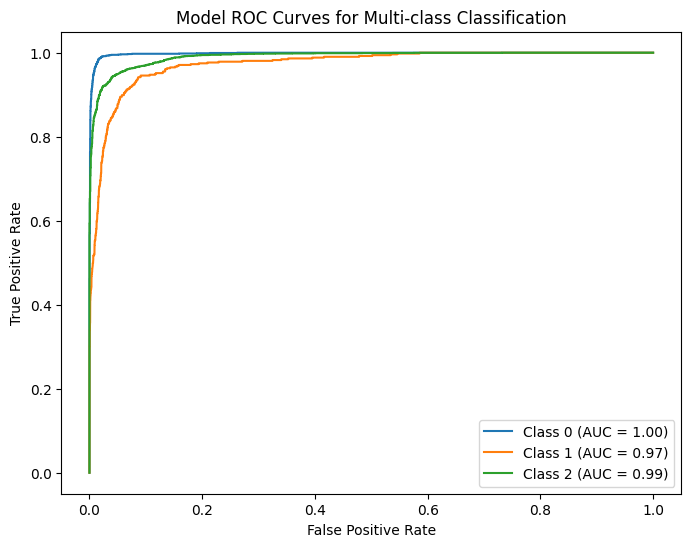

In [97]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_test_encoded and y_pred_prob are defined
# y_test_encoded: True labels (encoded, not one-hot encoded)
# y_pred_prob: Predicted probabilities for each class

# Calculate ROC-AUC score for model (one-vs-all approach for multi-class)
roc_auc = []

# Create a figure and axis
plt.figure(figsize=(8, 6))

# Plot ROC curve for each class
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test== i, y_pred_prob[:, i])
    roc_auc_class = auc(fpr, tpr)
    roc_auc.append(roc_auc_class * 100.0)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc_class:.2f})')

# Set plot title and labels
plt.title("Model ROC Curves for Multi-class Classification")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

## Converting y_train and y_test to one_hot

In [98]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical


label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_original)
y_test_encoded = label_encoder.transform(y_test_original)

# Convert integer labels to one-hot encoding
y_train_one_hot = to_categorical(y_train_encoded)
y_test_one_hot = to_categorical(y_test_encoded)

# Check the shapes
print(y_train_one_hot.shape, y_test_one_hot.shape)

(13312, 3) (5706, 3)


## Model 8 Stacked LSTM

In [99]:
# Output Directory name:
output_dir = 'model_output/Stacked-LSTM' # Store model's parameter after each epoch, useful at a later time

# If the output_dir directory doesn't exist, we use the mkdirs() method to make it
if not os.path.exists(output_dir):
  os.makedirs(output_dir)

# Allow to save our model parameters after each epoch during training
modelcheckpoint = ModelCheckpoint(filepath = output_dir + '/weights.{epoch:02d}.hdf5')

In [100]:
model8 = Sequential()
model8.add(Embedding(n_unique_words, n_dim, input_length=max_message_length))
model8.add(LSTM(100, return_sequences=True))
model8.add(Dropout(dropout))
model8.add(LSTM(100))
model8.add(Dropout(dropout))
model8.add(Dense(num_classes, activation='softmax'))  # Adjust the activation function
model8.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model8.summary()

start_time = time.time()
history8 = model8.fit(x_train, y_train_one_hot, validation_data=(x_test, y_test_one_hot), epochs=epochs, batch_size=batch_size, callbacks=[modelcheckpoint])
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 100, 100)          500000    
                                                                 
 lstm_3 (LSTM)               (None, 100, 100)          80400     
                                                                 
 dropout_4 (Dropout)         (None, 100, 100)          0         
                                                                 
 lstm_4 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_12 (Dense)            (None, 3)                 303       
                                                                 
Total params: 661103 (2.52 MB)
Trainable params: 66110

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


104/104 [==============================] - 5s 49ms/step - loss: 0.1533 - accuracy: 0.9454 - val_loss: 0.1544 - val_accuracy: 0.9374
Epoch 3/7
104/104 [==============================] - 4s 38ms/step - loss: 0.0975 - accuracy: 0.9646 - val_loss: 0.1659 - val_accuracy: 0.9458
Epoch 4/7
104/104 [==============================] - 4s 38ms/step - loss: 0.0733 - accuracy: 0.9745 - val_loss: 0.1693 - val_accuracy: 0.9395
Epoch 5/7
104/104 [==============================] - 3s 28ms/step - loss: 0.0569 - accuracy: 0.9780 - val_loss: 0.2123 - val_accuracy: 0.9434
Epoch 6/7
104/104 [==============================] - 3s 25ms/step - loss: 0.0496 - accuracy: 0.9811 - val_loss: 0.1866 - val_accuracy: 0.9416
Epoch 7/7
104/104 [==============================] - 3s 25ms/step - loss: 0.0469 - accuracy: 0.9811 - val_loss: 0.1900 - val_accuracy: 0.9404

Duration: 43 seconds


### Evaluate

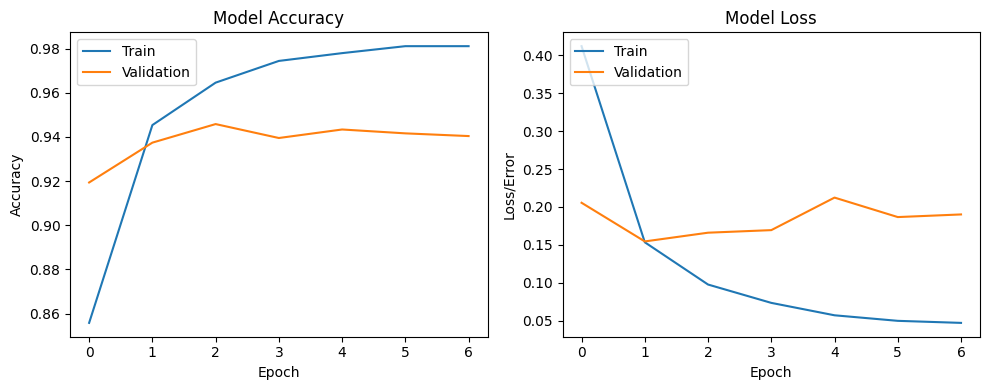

In [101]:
plt.figure(figsize=(10, 4))

# Visualizing training and validation accuracy for this Model
plt.subplot(1, 2, 1)
plt.plot(history8.history['accuracy'])
plt.plot(history8.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Visualizing training and validation loss for this Model
plt.subplot(1, 2, 2)
plt.plot(history8.history['loss'])
plt.plot(history8.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss/Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [102]:
from sklearn.metrics import accuracy_score
import numpy as np

# Evaluating the model
y_pred_prob = model8.predict(x_test)
y_pred = y_pred_prob.argmax(axis=-1)

# Calculating accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {100*accuracy:.2f}")

179/179 [==============================] - 2s 6ms/step
Model Accuracy: 94.04


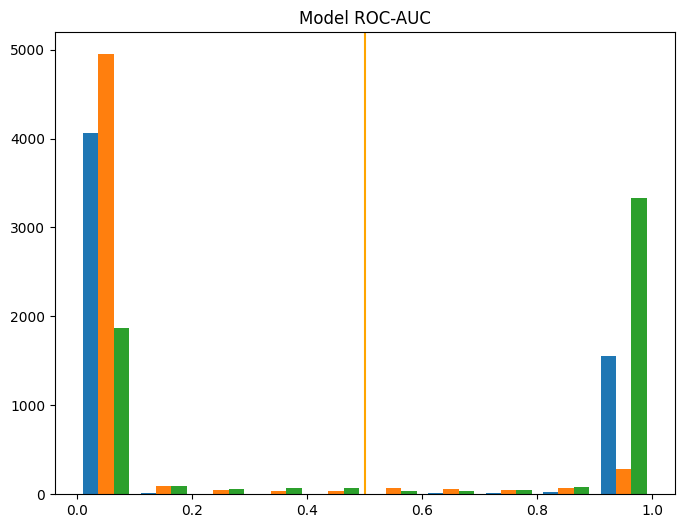

In [103]:
# Plot ROC curve for model
plt.figure(figsize=(8, 6))
plt.hist(y_pred_prob)
_ = plt.axvline(x=0.5, color='orange')
plt.title("Model ROC-AUC")
plt.show()

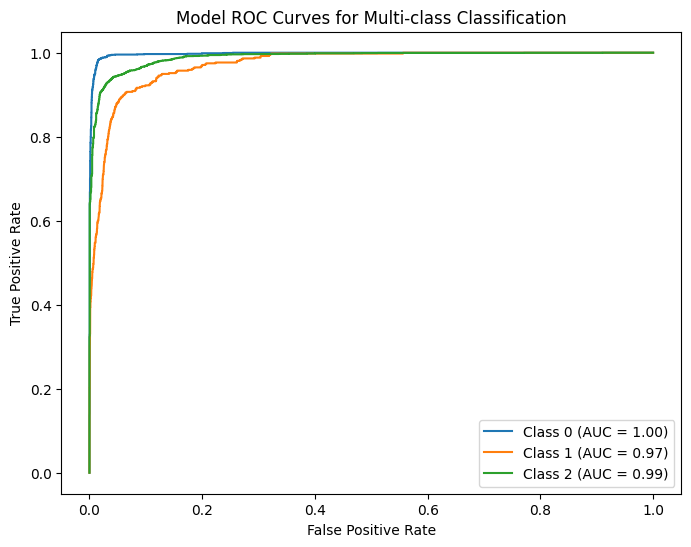

In [104]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_test_encoded and y_pred_prob are defined
# y_test_encoded: True labels (encoded, not one-hot encoded)
# y_pred_prob: Predicted probabilities for each class

# Calculate ROC-AUC score for model (one-vs-all approach for multi-class)
roc_auc = []

# Create a figure and axis
plt.figure(figsize=(8, 6))

# Plot ROC curve for each class
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test== i, y_pred_prob[:, i])
    roc_auc_class = auc(fpr, tpr)
    roc_auc.append(roc_auc_class * 100.0)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc_class:.2f})')

# Set plot title and labels
plt.title("Model ROC Curves for Multi-class Classification")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

## Model 9 Conv-LSTM

In [105]:
# Output Directory name:
output_dir = 'model_output/CNN-LSTM' # Store model's parameter after each epoch, useful at a later time

# If the output_dir directory doesn't exist, we use the mkdirs() method to make it
if not os.path.exists(output_dir):
  os.makedirs(output_dir)

# Allow to save our model parameters after each epoch during training
modelcheckpoint = ModelCheckpoint(filepath = output_dir + '/weights.{epoch:02d}.hdf5')

In [ ]:
model9 = Sequential()
model9.add(Embedding(n_unique_words, n_dim, input_length=max_message_length))
model9.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model9.add(MaxPooling1D(pool_size=2))
model9.add(LSTM(100))
model9.add(Dropout(dropout))
model9.add(Dense(num_classes, activation='softmax'))  # Adjust the activation function
model9.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model9.summary()

start_time = time.time()
history9 = model9.fit(x_train, y_train_one_hot, validation_data=(x_test, y_test_one_hot), epochs=epochs, batch_size=batch_size, callbacks=[modelcheckpoint])
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 100, 100)          500000    
                                                                 
 conv1d_2 (Conv1D)           (None, 100, 32)           9632      
                                                                 
 max_pooling1d (MaxPooling1  (None, 50, 32)            0         
 D)                                                              
                                                                 
 lstm_5 (LSTM)               (None, 100)               53200     
                                                                 
 dropout_6 (Dropout)         (None, 100)               0         
                                                                 
 dense_13 (Dense)            (None, 3)                 303       
                                                      

### Evaluate

In [ ]:
plt.figure(figsize=(10, 4))

# Visualizing training and validation accuracy for this Model
plt.subplot(1, 2, 1)
plt.plot(history9.history['accuracy'])
plt.plot(history9.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Visualizing training and validation loss for this Model
plt.subplot(1, 2, 2)
plt.plot(history9.history['loss'])
plt.plot(history9.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss/Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np

# Evaluating the model
y_pred_prob = model9.predict(x_test)
y_pred = y_pred_prob.argmax(axis=-1)

# Calculating accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {100*accuracy:.2f}")

In [ ]:
# Plot ROC curve for model
plt.figure(figsize=(8, 6))
plt.hist(y_pred_prob)
_ = plt.axvline(x=0.5, color='orange')
plt.title("Model ROC-AUC")
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_test_encoded and y_pred_prob are defined
# y_test_encoded: True labels (encoded, not one-hot encoded)
# y_pred_prob: Predicted probabilities for each class

# Calculate ROC-AUC score for model (one-vs-all approach for multi-class)
roc_auc = []

# Create a figure and axis
plt.figure(figsize=(8, 6))

# Plot ROC curve for each class
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test== i, y_pred_prob[:, i])
    roc_auc_class = auc(fpr, tpr)
    roc_auc.append(roc_auc_class * 100.0)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc_class:.2f})')

# Set plot title and labels
plt.title("Model ROC Curves for Multi-class Classification")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

## Model 10 Multi-ConvNet

In [ ]:
# Output Directory name:
output_dir = 'model_output/Multi-CovNet' # Store model's parameter after each epoch, useful at a later time

# If the output_dir directory doesn't exist, we use the mkdirs() method to make it
if not os.path.exists(output_dir):
  os.makedirs(output_dir)

# Allow to save our model parameters after each epoch during training
modelcheckpoint = ModelCheckpoint(filepath = output_dir + '/weights.{epoch:02d}.hdf5')

In [ ]:
model10 = Sequential()
model10.add(Embedding(n_unique_words, n_dim, input_length=max_message_length))
model10.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
model10.add(GlobalMaxPooling1D())
model10.add(Dropout(dropout))
model10.add(Dense(512, activation='relu'))
model10.add(Dropout(dropout))
model10.add(Dense(num_classes, activation='softmax'))
model10.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model10.summary()

start_time = time.time()
history10 = model10.fit(x_train, y_train_one_hot, validation_data=(x_test, y_test_one_hot), epochs=epochs, batch_size=batch_size, callbacks=[modelcheckpoint])
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

### Evaluate

In [ ]:
plt.figure(figsize=(10, 4))

# Visualizing training and validation accuracy for this Model
plt.subplot(1, 2, 1)
plt.plot(history10.history['accuracy'])
plt.plot(history10.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Visualizing training and validation loss for this Model
plt.subplot(1, 2, 2)
plt.plot(history10.history['loss'])
plt.plot(history10.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss/Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np

# Evaluating the model
y_pred_prob = model10.predict(x_test)
y_pred = y_pred_prob.argmax(axis=-1)

# Calculating accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {100*accuracy:.2f}")

In [ ]:
# Plot ROC curve for model
plt.figure(figsize=(8, 6))
plt.hist(y_pred_prob)
_ = plt.axvline(x=0.5, color='orange')
plt.title("Model ROC-AUC")
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_test_encoded and y_pred_prob are defined
# y_test_encoded: True labels (encoded, not one-hot encoded)
# y_pred_prob: Predicted probabilities for each class

# Calculate ROC-AUC score for model (one-vs-all approach for multi-class)
roc_auc = []

# Create a figure and axis
plt.figure(figsize=(8, 6))

# Plot ROC curve for each class
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test== i, y_pred_prob[:, i])
    roc_auc_class = auc(fpr, tpr)
    roc_auc.append(roc_auc_class * 100.0)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc_class:.2f})')

# Set plot title and labels
plt.title("Model ROC Curves for Multi-class Classification")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

## Model 11 CNN-LSTM

In [ ]:
# Output Directory name:
output_dir = 'model_output/CNN-LSTM Part 2' # Store model's parameter after each epoch, useful at a later time

# If the output_dir directory doesn't exist, we use the mkdirs() method to make it
if not os.path.exists(output_dir):
  os.makedirs(output_dir)

# Allow to save our model parameters after each epoch during training
modelcheckpoint = ModelCheckpoint(filepath = output_dir + '/weights.{epoch:02d}.hdf5')

In [ ]:
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding
from keras.layers import LSTM
from keras.layers import SpatialDropout1D, Conv1D, GlobalMaxPooling1D # new!
from keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
# output directory name:
output_dir = 'model_output/conv'

drop_embed = 0.2 # new!
# convolutional layer architecture:
#n_conv = 256 # filters, a.k.a. kernels
#k_conv = 3 # kernel length
# dense layer architecture:
n_lstm = 256
drop_lstm = 0.2

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, SpatialDropout1D, LSTM, Dense

model11 = Sequential()
model11.add(Embedding(n_unique_words, n_dim, input_length=max_message_length))
model11.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model11.add(MaxPooling1D(pool_size=2))
model11.add(LSTM(100))
model11.add(Dropout(dropout))
model11.add(Dense(num_classes, activation='softmax'))
model11.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the summary of the model
model11.summary()

# Fitting the model
start_time = time.time()
history11 = model11.fit(x_train, y_train_one_hot, validation_data=(x_test, y_test_one_hot), epochs=epochs, batch_size=batch_size, callbacks=[modelcheckpoint])
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

### Evaluate

In [ ]:
plt.figure(figsize=(10, 4))

# Visualizing training and validation accuracy for this Model
plt.subplot(1, 2, 1)
plt.plot(history11.history['accuracy'])
plt.plot(history11.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Visualizing training and validation loss for this Model
plt.subplot(1, 2, 2)
plt.plot(history11.history['loss'])
plt.plot(history11.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss/Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np

# Evaluating the model
y_pred_prob = model11.predict(x_test)
y_pred = y_pred_prob.argmax(axis=-1)

# Calculating accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {100*accuracy:.2f}")

In [ ]:
# Plot ROC curve for model
plt.figure(figsize=(8, 6))
plt.hist(y_pred_prob)
_ = plt.axvline(x=0.5, color='orange')
plt.title("Model ROC-AUC")
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_test_encoded and y_pred_prob are defined
# y_test_encoded: True labels (encoded, not one-hot encoded)
# y_pred_prob: Predicted probabilities for each class

# Calculate ROC-AUC score for model (one-vs-all approach for multi-class)
roc_auc = []

# Create a figure and axis
plt.figure(figsize=(8, 6))

# Plot ROC curve for each class
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test== i, y_pred_prob[:, i])
    roc_auc_class = auc(fpr, tpr)
    roc_auc.append(roc_auc_class * 100.0)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc_class:.2f})')

# Set plot title and labels
plt.title("Model ROC Curves for Multi-class Classification")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

## Model 12 Dilated Convolutional Neural Network (DCNN)

In [ ]:
# Output Directory name:
output_dir = 'model_output/DCNN' # Store model's parameter after each epoch, useful at a later time

# If the output_dir directory doesn't exist, we use the mkdirs() method to make it
if not os.path.exists(output_dir):
  os.makedirs(output_dir)

# Allow to save our model parameters after each epoch during training
modelcheckpoint = ModelCheckpoint(filepath = output_dir + '/weights.{epoch:02d}.hdf5')

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dropout, Dense

model12 = Sequential()
model12.add(Embedding(n_unique_words, n_dim, input_length=max_message_length))
model12.add(Conv1D(filters=64, kernel_size=3, dilation_rate=2, activation='relu'))
model12.add(GlobalMaxPooling1D())
model12.add(Dense(128, activation='relu'))
model12.add(Dropout(0.5))
model12.add(Dense(num_classes, activation='softmax'))

model12.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model12.summary()

start_time = time.time()
history12 = model12.fit(x_train, y_train_one_hot, validation_data=(x_test, y_test_one_hot), epochs=epochs, batch_size=batch_size, callbacks=[modelcheckpoint])
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

### Evaluate

In [ ]:
plt.figure(figsize=(10, 4))

# Visualizing training and validation accuracy for this Model
plt.subplot(1, 2, 1)
plt.plot(history12.history['accuracy'])
plt.plot(history12.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Visualizing training and validation loss for this Model
plt.subplot(1, 2, 2)
plt.plot(history12.history['loss'])
plt.plot(history12.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss/Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np

# Evaluating the model
y_pred_prob = model12.predict(x_test)
y_pred = y_pred_prob.argmax(axis=-1)

# Calculating accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {100*accuracy:.2f}")

In [ ]:
# Plot ROC curve for model
plt.figure(figsize=(8, 6))
plt.hist(y_pred_prob)
_ = plt.axvline(x=0.5, color='orange')
plt.title("Model ROC-AUC")
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_test_encoded and y_pred_prob are defined
# y_test_encoded: True labels (encoded, not one-hot encoded)
# y_pred_prob: Predicted probabilities for each class

# Calculate ROC-AUC score for model (one-vs-all approach for multi-class)
roc_auc = []

# Create a figure and axis
plt.figure(figsize=(8, 6))

# Plot ROC curve for each class
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test== i, y_pred_prob[:, i])
    roc_auc_class = auc(fpr, tpr)
    roc_auc.append(roc_auc_class * 100.0)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc_class:.2f})')

# Set plot title and labels
plt.title("Model ROC Curves for Multi-class Classification")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

## Model 13 Residual Network (ResNet)

In [ ]:
# Output Directory name:
output_dir = 'model_output/Resnet' # Store model's parameter after each epoch, useful at a later time

# If the output_dir directory doesn't exist, we use the mkdirs() method to make it
if not os.path.exists(output_dir):
  os.makedirs(output_dir)

# Allow to save our model parameters after each epoch during training
modelcheckpoint = ModelCheckpoint(filepath = output_dir + '/weights.{epoch:02d}.hdf5')

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense

model13 = Sequential()
model13.add(Embedding(n_unique_words, n_dim, input_length=max_message_length))
model13.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
model13.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
model13.add(MaxPooling1D(pool_size=2))
model13.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
model13.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
model13.add(MaxPooling1D(pool_size=2))
model13.add(GlobalAveragePooling1D())
model13.add(Dense(128, activation='relu'))
model13.add(Dense(num_classes, activation='softmax'))

model13.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model13.summary()

start_time = time.time()
history13 = model13.fit(x_train, y_train_one_hot, validation_data=(x_test, y_test_one_hot), epochs=epochs, batch_size=batch_size, callbacks=[modelcheckpoint])
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

### Evaluate

In [ ]:
plt.figure(figsize=(10, 4))

# Visualizing training and validation accuracy for this Model
plt.subplot(1, 2, 1)
plt.plot(history13.history['accuracy'])
plt.plot(history13.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Visualizing training and validation loss for this Model
plt.subplot(1, 2, 2)
plt.plot(history13.history['loss'])
plt.plot(history13.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss/Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np

# Evaluating the model
y_pred_prob = model13.predict(x_test)
y_pred = y_pred_prob.argmax(axis=-1)

# Calculating accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {100*accuracy:.2f}")

In [ ]:
# Plot ROC curve for model
plt.figure(figsize=(8, 6))
plt.hist(y_pred_prob)
_ = plt.axvline(x=0.5, color='orange')
plt.title("Model ROC-AUC")
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_test_encoded and y_pred_prob are defined
# y_test_encoded: True labels (encoded, not one-hot encoded)
# y_pred_prob: Predicted probabilities for each class

# Calculate ROC-AUC score for model (one-vs-all approach for multi-class)
roc_auc = []

# Create a figure and axis
plt.figure(figsize=(8, 6))

# Plot ROC curve for each class
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test== i, y_pred_prob[:, i])
    roc_auc_class = auc(fpr, tpr)
    roc_auc.append(roc_auc_class * 100.0)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc_class:.2f})')

# Set plot title and labels
plt.title("Model ROC Curves for Multi-class Classification")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

## Model 14 Variational autoencoder (VAE) Network

In [ ]:
# Output Directory name:
output_dir = 'model_output/VAE' # Store model's parameter after each epoch, useful at a later time

# If the output_dir directory doesn't exist, we use the mkdirs() method to make it
if not os.path.exists(output_dir):
  os.makedirs(output_dir)

# Allow to save our model parameters after each epoch during training
modelcheckpoint = ModelCheckpoint(filepath = output_dir + '/weights.{epoch:02d}.hdf5')

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Lambda, Input
from keras import backend as K
from keras.models import Model

# Define the input layer
input_layer = Input(shape=(max_message_length,))

# Embedding layer
embedding_layer = Embedding(input_dim=n_unique_words, output_dim=n_dim, input_length=max_message_length)(input_layer)

# Flatten the embedding output
flatten_layer = Flatten()(embedding_layer)

# Intermediate dense layers
hidden_layer_1 = Dense(128, activation='relu')(flatten_layer)
hidden_layer_2 = Dense(64, activation='relu')(hidden_layer_1)

# Output layers for mean and log variance
z_mean = Dense(32, name='z_mean')(hidden_layer_2)
z_log_var = Dense(32, name='z_log_var')(hidden_layer_2)

# Sampling function
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Create a Lambda layer for the sampling function
z = Lambda(sampling, output_shape=(32,), name='z')([z_mean, z_log_var])

# Dense layer with softmax activation for multiclass classification
output_layer = Dense(num_classes, activation='softmax', name='output')(z)

# Create a new model with input and output layers
model14 = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model14.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model14.summary()

start_time = time.time()
history14 = model14.fit(x_train, y_train_one_hot, validation_data=(x_test, y_test_one_hot), epochs=epochs, batch_size=batch_size, callbacks=[modelcheckpoint])
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

### Evaluate

In [ ]:
plt.figure(figsize=(10, 4))

# Visualizing training and validation accuracy for this Model
plt.subplot(1, 2, 1)
plt.plot(history14.history['accuracy'])
plt.plot(history14.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Visualizing training and validation loss for this Model
plt.subplot(1, 2, 2)
plt.plot(history14.history['loss'])
plt.plot(history14.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss/Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np

# Evaluating the model
y_pred_prob = model14.predict(x_test)
y_pred = y_pred_prob.argmax(axis=-1)

# Calculating accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {100*accuracy:.2f}")

In [ ]:
# Plot ROC curve for model
plt.figure(figsize=(8, 6))
plt.hist(y_pred_prob)
_ = plt.axvline(x=0.5, color='orange')
plt.title("Model ROC-AUC")
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_test_encoded and y_pred_prob are defined
# y_test_encoded: True labels (encoded, not one-hot encoded)
# y_pred_prob: Predicted probabilities for each class

# Calculate ROC-AUC score for model (one-vs-all approach for multi-class)
roc_auc = []

# Create a figure and axis
plt.figure(figsize=(8, 6))

# Plot ROC curve for each class
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test== i, y_pred_prob[:, i])
    roc_auc_class = auc(fpr, tpr)
    roc_auc.append(roc_auc_class * 100.0)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc_class:.2f})')

# Set plot title and labels
plt.title("Model ROC Curves for Multi-class Classification")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

## Model 15 Bi-GRU

In [ ]:
# Output Directory name:
output_dir = 'model_output/Bi-GRU' # Store model's parameter after each epoch, useful at a later time

# If the output_dir directory doesn't exist, we use the mkdirs() method to make it
if not os.path.exists(output_dir):
  os.makedirs(output_dir)

# Allow to save our model parameters after each epoch during training
modelcheckpoint = ModelCheckpoint(filepath = output_dir + '/weights.{epoch:02d}.hdf5')

In [ ]:
from keras.layers import Bidirectional, GRU, Dense

model15 = Sequential()
model15.add(Embedding(n_unique_words, n_dim, input_length=max_message_length))
model15.add(Bidirectional(GRU(64)))
model15.add(Dense(64, activation='relu'))
model15.add(Dense(num_classes, activation='softmax'))
model15.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model15.summary()

start_time = time.time()
history15 = model15.fit(x_train, y_train_one_hot, validation_data=(x_test, y_test_one_hot), epochs=epochs, batch_size=batch_size, callbacks=[modelcheckpoint])
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

### Evaluate

In [ ]:
plt.figure(figsize=(10, 4))

# Visualizing training and validation accuracy for this Model
plt.subplot(1, 2, 1)
plt.plot(history15.history['accuracy'])
plt.plot(history15.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Visualizing training and validation loss for this Model
plt.subplot(1, 2, 2)
plt.plot(history15.history['loss'])
plt.plot(history15.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss/Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np

# Evaluating the model
y_pred_prob = model15.predict(x_test)
y_pred = y_pred_prob.argmax(axis=-1)

# Calculating accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {100*accuracy:.2f}")

In [ ]:
# Plot ROC curve for model
plt.figure(figsize=(8, 6))
plt.hist(y_pred_prob)
_ = plt.axvline(x=0.5, color='orange')
plt.title("Model ROC-AUC")
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_test_encoded and y_pred_prob are defined
# y_test_encoded: True labels (encoded, not one-hot encoded)
# y_pred_prob: Predicted probabilities for each class

# Calculate ROC-AUC score for model (one-vs-all approach for multi-class)
roc_auc = []

# Create a figure and axis
plt.figure(figsize=(8, 6))

# Plot ROC curve for each class
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test== i, y_pred_prob[:, i])
    roc_auc_class = auc(fpr, tpr)
    roc_auc.append(roc_auc_class * 100.0)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc_class:.2f})')

# Set plot title and labels
plt.title("Model ROC Curves for Multi-class Classification")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

## Model 16 Multi-Layer Perceptron (MLP)

In [ ]:
# Output Directory name:
output_dir = 'model_output/MLP' # Store model's parameter after each epoch, useful at a later time

# If the output_dir directory doesn't exist, we use the mkdirs() method to make it
if not os.path.exists(output_dir):
  os.makedirs(output_dir)

# Allow to save our model parameters after each epoch during training
modelcheckpoint = ModelCheckpoint(filepath = output_dir + '/weights.{epoch:02d}.hdf5')

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten

model16 = Sequential()
model16.add(Dense(512, activation='relu', input_shape=(100,)))
model16.add(Dense(256, activation='relu'))
model16.add(Dense(128, activation='relu'))
model16.add(Dense(64, activation='relu'))
model16.add(Dense(32, activation='relu'))
model16.add(Dense(num_classes, activation='softmax'))
model16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model16.summary()

start_time = time.time()
history16 = model16.fit(x_train, y_train_one_hot, validation_data=(x_test, y_test_one_hot), epochs=epochs, batch_size=batch_size, callbacks=[modelcheckpoint])
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

### Evaluate

In [ ]:
plt.figure(figsize=(10, 4))

# Visualizing training and validation accuracy for this Model
plt.subplot(1, 2, 1)
plt.plot(history16.history['accuracy'])
plt.plot(history16.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Visualizing training and validation loss for this Model
plt.subplot(1, 2, 2)
plt.plot(history16.history['loss'])
plt.plot(history16.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss/Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np

# Evaluating the model
y_pred_prob = model16.predict(x_test)
y_pred = y_pred_prob.argmax(axis=-1)

# Calculating accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {100*accuracy:.2f}")

In [ ]:
# Plot ROC curve for model
plt.figure(figsize=(8, 6))
plt.hist(y_pred_prob)
_ = plt.axvline(x=0.5, color='orange')
plt.title("Model ROC-AUC")
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_test_encoded and y_pred_prob are defined
# y_test_encoded: True labels (encoded, not one-hot encoded)
# y_pred_prob: Predicted probabilities for each class

# Calculate ROC-AUC score for model (one-vs-all approach for multi-class)
roc_auc = []

# Create a figure and axis
plt.figure(figsize=(8, 6))

# Plot ROC curve for each class
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test== i, y_pred_prob[:, i])
    roc_auc_class = auc(fpr, tpr)
    roc_auc.append(roc_auc_class * 100.0)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc_class:.2f})')

# Set plot title and labels
plt.title("Model ROC Curves for Multi-class Classification")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

## Model 17 CNN-GRU

In [ ]:
# Output Directory name:
output_dir = 'model_output/CNN-GRU' # Store model's parameter after each epoch, useful at a later time

# If the output_dir directory doesn't exist, we use the mkdirs() method to make it
if not os.path.exists(output_dir):
  os.makedirs(output_dir)

# Allow to save our model parameters after each epoch during training
modelcheckpoint = ModelCheckpoint(filepath = output_dir + '/weights.{epoch:02d}.hdf5')

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, GRU, Dense, Dropout, Flatten


model17 = Sequential()

# Embedding layer
model17.add(Embedding(n_unique_words, n_dim, input_length=max_message_length))

# Convolutional layers
model17.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model17.add(MaxPooling1D(pool_size=2))

# GRU layer
model17.add(GRU(100, dropout=dropout, recurrent_dropout=dropout))

# Fully connected layers
model17.add(Dense(64, activation='relu'))
model17.add(Dropout(dropout))

# Output layer
model17.add(Dense(num_classes, activation='softmax'))

# Compile the model
model17.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the summary of the model
model17.summary()

start_time = time.time()
history17 = model17.fit(x_train, y_train_one_hot, validation_data=(x_test, y_test_one_hot), epochs=epochs, batch_size=batch_size, callbacks=[modelcheckpoint])
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

In [ ]:
# Evaluate the model on the test set
loss17, accuracy17 = model17.evaluate(x_test, y_test_one_hot)
print(f'Test Loss: {loss17}, Test Accuracy: {100*accuracy17:.2f}')

### Evaluate

In [ ]:
plt.figure(figsize=(10, 4))

# Visualizing training and validation accuracy for this Model
plt.subplot(1, 2, 1)
plt.plot(history17.history['accuracy'])
plt.plot(history17.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Visualizing training and validation loss for this Model
plt.subplot(1, 2, 2)
plt.plot(history17.history['loss'])
plt.plot(history17.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss/Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np

# Evaluating the model
y_pred_prob = model17.predict(x_test)
y_pred = y_pred_prob.argmax(axis=-1)


# Calculating accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {100*accuracy:.2f}")

In [ ]:
# Plot ROC curve for model
plt.figure(figsize=(8, 6))
plt.hist(y_pred_prob)
_ = plt.axvline(x=0.5, color='orange')
plt.title("Model ROC-AUC")
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_test_encoded and y_pred_prob are defined
# y_test_encoded: True labels (encoded, not one-hot encoded)
# y_pred_prob: Predicted probabilities for each class

# Calculate ROC-AUC score for model (one-vs-all approach for multi-class)
roc_auc = []

# Create a figure and axis
plt.figure(figsize=(8, 6))

# Plot ROC curve for each class
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test== i, y_pred_prob[:, i])
    roc_auc_class = auc(fpr, tpr)
    roc_auc.append(roc_auc_class * 100.0)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc_class:.2f})')

# Set plot title and labels
plt.title("Model ROC Curves for Multi-class Classification")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

## Model 18 CNN + Bi-GRU

In [ ]:
# Output Directory name:
output_dir = 'model_output/CNN-Bi-GRU' # Store model's parameter after each epoch, useful at a later time

# If the output_dir directory doesn't exist, we use the mkdirs() method to make it
if not os.path.exists(output_dir):
  os.makedirs(output_dir)

# Allow to save our model parameters after each epoch during training
modelcheckpoint = ModelCheckpoint(filepath = output_dir + '/weights.{epoch:02d}.hdf5')

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, GRU, Dense, Dropout, Flatten


model18 = Sequential()

# Embedding layer
model18.add(Embedding(n_unique_words, n_dim, input_length=max_message_length))

# Convolutional layers
model18.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model18.add(MaxPooling1D(pool_size=2))

# Bidirectional GRU layer
model18.add(Bidirectional(GRU(100, dropout=dropout, recurrent_dropout=dropout)))

# Fully connected layers
model18.add(Dense(64, activation='relu'))
model18.add(Dropout(dropout))

# Output layer
model18.add(Dense(num_classes, activation='softmax'))

# Compile the model
model18.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the summary of the model
model18.summary()

start_time = time.time()
history18 = model18.fit(x_train, y_train_one_hot, validation_data=(x_test, y_test_one_hot), epochs=epochs, batch_size=batch_size, callbacks=[modelcheckpoint])
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

In [ ]:
# Evaluate the model on the test set
loss18, accuracy18 = model18.evaluate(x_test, y_test_one_hot)
print(f'Test Loss: {loss18}, Test Accuracy: {100*accuracy18:.2f}')

### Evaluate

In [ ]:
plt.figure(figsize=(10, 4))

# Visualizing training and validation accuracy for this Model
plt.subplot(1, 2, 1)
plt.plot(history18.history['accuracy'])
plt.plot(history18.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Visualizing training and validation loss for this Model
plt.subplot(1, 2, 2)
plt.plot(history18.history['loss'])
plt.plot(history18.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss/Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np

# Evaluating the model
y_pred_prob = model18.predict(x_test)
y_pred = y_pred_prob.argmax(axis=-1)

# Calculating accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {100*accuracy:.2f}")

In [ ]:
# Plot ROC curve for model
plt.figure(figsize=(8, 6))
plt.hist(y_pred_prob)
_ = plt.axvline(x=0.5, color='orange')
plt.title("Model ROC-AUC")
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_test_encoded and y_pred_prob are defined
# y_test_encoded: True labels (encoded, not one-hot encoded)
# y_pred_prob: Predicted probabilities for each class

# Calculate ROC-AUC score for model (one-vs-all approach for multi-class)
roc_auc = []

# Create a figure and axis
plt.figure(figsize=(8, 6))

# Plot ROC curve for each class
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test== i, y_pred_prob[:, i])
    roc_auc_class = auc(fpr, tpr)
    roc_auc.append(roc_auc_class * 100.0)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc_class:.2f})')

# Set plot title and labels
plt.title("Model ROC Curves for Multi-class Classification")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

## Model 19 CNN + Bi-LSTM

In [ ]:
# Output Directory name:
output_dir = 'model_output/CNN-Bi-LSTM' # Store model's parameter after each epoch, useful at a later time

# If the output_dir directory doesn't exist, we use the mkdirs() method to make it
if not os.path.exists(output_dir):
  os.makedirs(output_dir)

# Allow to save our model parameters after each epoch during training
modelcheckpoint = ModelCheckpoint(filepath = output_dir + '/weights.{epoch:02d}.hdf5')

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, Flatten


model19 = Sequential()

# Embedding layer
model19.add(Embedding(n_unique_words, n_dim, input_length=max_message_length))

# Convolutional layers
model19.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model19.add(MaxPooling1D(pool_size=2))

# Bidirectional LSTM layer
model19.add(Bidirectional(LSTM(100, dropout=dropout, recurrent_dropout=dropout)))

# Fully connected layers
model19.add(Dense(64, activation='relu'))
model19.add(Dropout(dropout))

# Output layer
model19.add(Dense(num_classes, activation='softmax'))

# Compile the model
model19.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the summary of the model
model19.summary()

start_time = time.time()
history19 = model19.fit(x_train, y_train_one_hot, validation_data=(x_test, y_test_one_hot), epochs=epochs, batch_size=batch_size, callbacks=[modelcheckpoint])
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

In [ ]:
# Evaluate the model on the test set
loss19, accuracy19 = model19.evaluate(x_test, y_test_one_hot)
print(f'Test Loss: {loss19}, Test Accuracy: {100*accuracy19:.2f}')

### Evaluate

In [ ]:
plt.figure(figsize=(10, 4))

# Visualizing training and validation accuracy for this Model
plt.subplot(1, 2, 1)
plt.plot(history19.history['accuracy'])
plt.plot(history19.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Visualizing training and validation loss for this Model
plt.subplot(1, 2, 2)
plt.plot(history19.history['loss'])
plt.plot(history19.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss/Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np

# Evaluating the model
y_pred_prob = model19.predict(x_test)
y_pred = y_pred_prob.argmax(axis=-1)

# Calculating accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {100*accuracy:.2f}")

In [ ]:
# Plot ROC curve for model
plt.figure(figsize=(8, 6))
plt.hist(y_pred_prob)
_ = plt.axvline(x=0.5, color='orange')
plt.title("Model ROC-AUC")
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_test_encoded and y_pred_prob are defined
# y_test_encoded: True labels (encoded, not one-hot encoded)
# y_pred_prob: Predicted probabilities for each class

# Calculate ROC-AUC score for model (one-vs-all approach for multi-class)
roc_auc = []

# Create a figure and axis
plt.figure(figsize=(8, 6))

# Plot ROC curve for each class
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test== i, y_pred_prob[:, i])
    roc_auc_class = auc(fpr, tpr)
    roc_auc.append(roc_auc_class * 100.0)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc_class:.2f})')

# Set plot title and labels
plt.title("Model ROC Curves for Multi-class Classification")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

## Model 20 BERT Model

In [ ]:
# Output Directory name:
output_dir = 'model_output/BERT' # Store model's parameter after each epoch, useful at a later time

# If the output_dir directory doesn't exist, we use the mkdirs() method to make it
if not os.path.exists(output_dir):
  os.makedirs(output_dir)

# Allow to save our model parameters after each epoch during training
modelcheckpoint = ModelCheckpoint(filepath = output_dir + '/weights.{epoch:02d}.hdf5')

In [ ]:
# Split the data into training and testing sets
X_train_for_tokens, X_val_for_tokens, y_train_for_tokens, y_val_for_tokens = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the training data
train_tokens = tokenizer(
    X_train_for_tokens.tolist(),
    truncation=True,
    padding=True,
    max_length=128,  # Adjust as needed
    return_tensors='tf',  # Use 'tf' for TensorFlow
)

# Tokenize the validation data
val_tokens = tokenizer(
    X_val_for_tokens.tolist(),
    truncation=True,
    padding=True,
    max_length=128,  # Adjust as needed
    return_tensors='tf',  # Use 'tf' for TensorFlow
)

# Display the tokenized input
print(train_tokens)
print(val_tokens)


In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from transformers import BertTokenizer, TFBertModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Load the BERT model with pooler layer set to non-trainable
bert_model = TFBertModel.from_pretrained('bert-base-uncased', trainable=False)

# Define the input layer
input_layer = Input(shape=(128,), dtype=tf.int32, name='input_ids')

# Connect the input layer to the BERT model
bert_output = bert_model(input_layer)[0]

# Global average pooling
pooled_output = tf.reduce_mean(bert_output, axis=1)

# Add a dense layer for classification
dense_layer = Dense(256, activation='relu')(pooled_output)

# Output layer for multiclass classification
output_layer = Dense(num_classes, activation='softmax')(dense_layer)

# Create the model
model_bert = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model_bert.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model_bert.summary()

In [ ]:
# Convert the labels to NumPy arrays and one-hot encode them
encoder = OneHotEncoder(sparse=False)
y_train_for_tokens_encoded = encoder.fit_transform(y_train_for_tokens.values.reshape(-1, 1))
y_val_for_tokens_encoded = encoder.transform(y_val_for_tokens.values.reshape(-1, 1))

In [ ]:
# Train the model
start_time = time.time()
history_model_bert = model_bert.fit(
    train_tokens['input_ids'],
    y_train_for_tokens_encoded,
    validation_data=(val_tokens['input_ids'], y_val_for_tokens_encoded),
    epochs=2,  # Adjust as needed
    batch_size=256,  # Adjust as needed
    callbacks=[modelcheckpoint]
)
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

In [ ]:
plt.figure(figsize=(10, 4))

# Visualizing training and validation accuracy for this Model
plt.subplot(1, 2, 1)
plt.plot(history_model_bert.history['accuracy'])
plt.plot(history_model_bert.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Visualizing training and validation loss for this Model
plt.subplot(1, 2, 2)
plt.plot(history_model_bert.history['loss'])
plt.plot(history_model_bert.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss/Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()